In [1]:
%run 'init.py'

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


### Basic RNNs with Tensorflow

Vectorization: output of layer of recurrent neurons for a mini-batch.

$$ Y_{(t)} = \phi(X_{(t)}.W_x + Y_{(t-1)}.W_y + b) = \phi(\begin{bmatrix} X_{(t)} & Y_{(t-1)} \end{bmatrix}.W + b) \space\space with \space\space W = \begin{bmatrix} W_x \\ W_y \end{bmatrix} $$

- $Y_{(t)}$ is $m \times n_{neurons}$ matrix containing layer's outputs at time step $t$ for each instance in the mini-batch
- $X_{(t)}$ is $m \times n_{inputs}$ matrix containing the inputs for all instances
- $W_x$ is $n_{inputs} \times n_{neurons}$ matrix containing connection weights for the **inputs** of the current time step
- $W_y$ is $n_{neurons} \times n_{neurons}$ matrix containing the connection weights for the **outputs** of the previous time step
- $W_x$ and $W_y$ are often concatenated into a single weight matrix $W$ of shape $(n_{inputs} + n_{neurons}) \times n_{neurons}$
- $b$ is a vector of size $n_{neurons}$ containing each neuron's bias term.

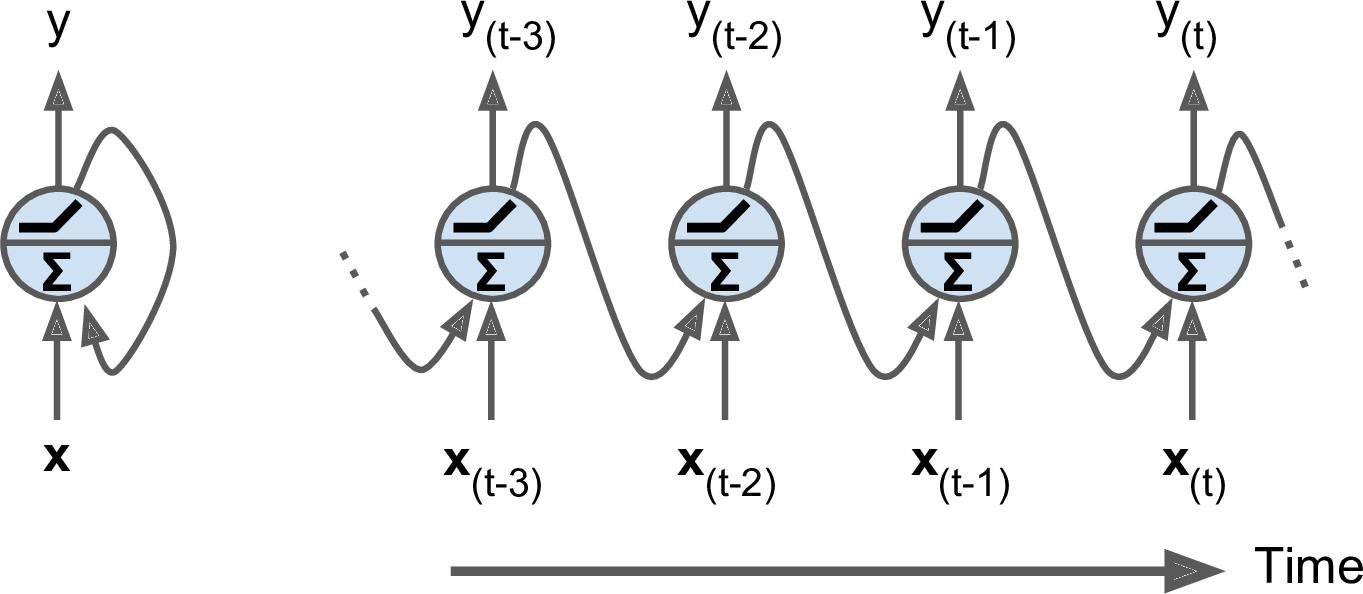

In [2]:
show_image('./images/img2739.jpg')

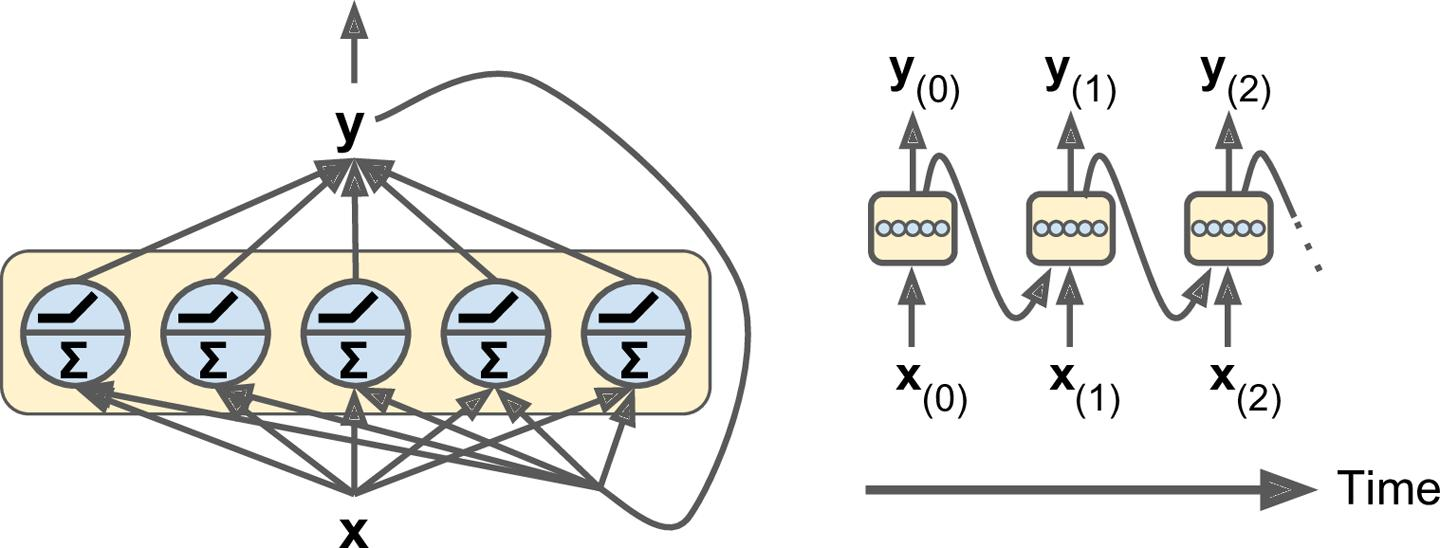

In [3]:
show_image('./images/img2740.jpg')

In [4]:
# We're going to implement a very basic RNN
# with two time steps and input vectors of size 3
n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons], dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons, n_neurons], dtype=tf.float32))
b = tf.Variable(tf.zeros(shape=[1, n_neurons], dtype=tf.float32))

# This network is different from a regular feedforward neural networks:
# - Weights and biases are shared between layers
# - Inputs are fed and outputs are taken out at each layer
Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(X1, Wx) + tf.matmul(Y0, Wy) + b)

# Our mini-batches, each batch has four instances.
#
# Imagine that we're processing sentences in our network.
# With the below dataset, we would have 4 sentences, and each of them
# will have two words (as we only consider two time steps).
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [5]:
print(Y0_val)

[[ 0.9831695   0.26544881  0.98882025 -0.94226336  0.99461228]
 [ 0.99667811 -0.99824494  1.         -0.99999988  1.        ]
 [ 0.99934787 -0.99999928  1.         -1.          1.        ]
 [-1.         -1.          1.         -0.9999941   0.99999952]]


In [6]:
print(Y1_val)

[[-0.87781209 -1.          1.         -1.          1.        ]
 [ 0.32438293  0.99914801  0.98633891  0.98977637  0.64038426]
 [-0.39357534 -0.99928832  1.         -0.99999988  1.        ]
 [-0.86130375  0.06614264  0.99999034 -0.99978191  0.99867225]]


### Static Unrolling throught time

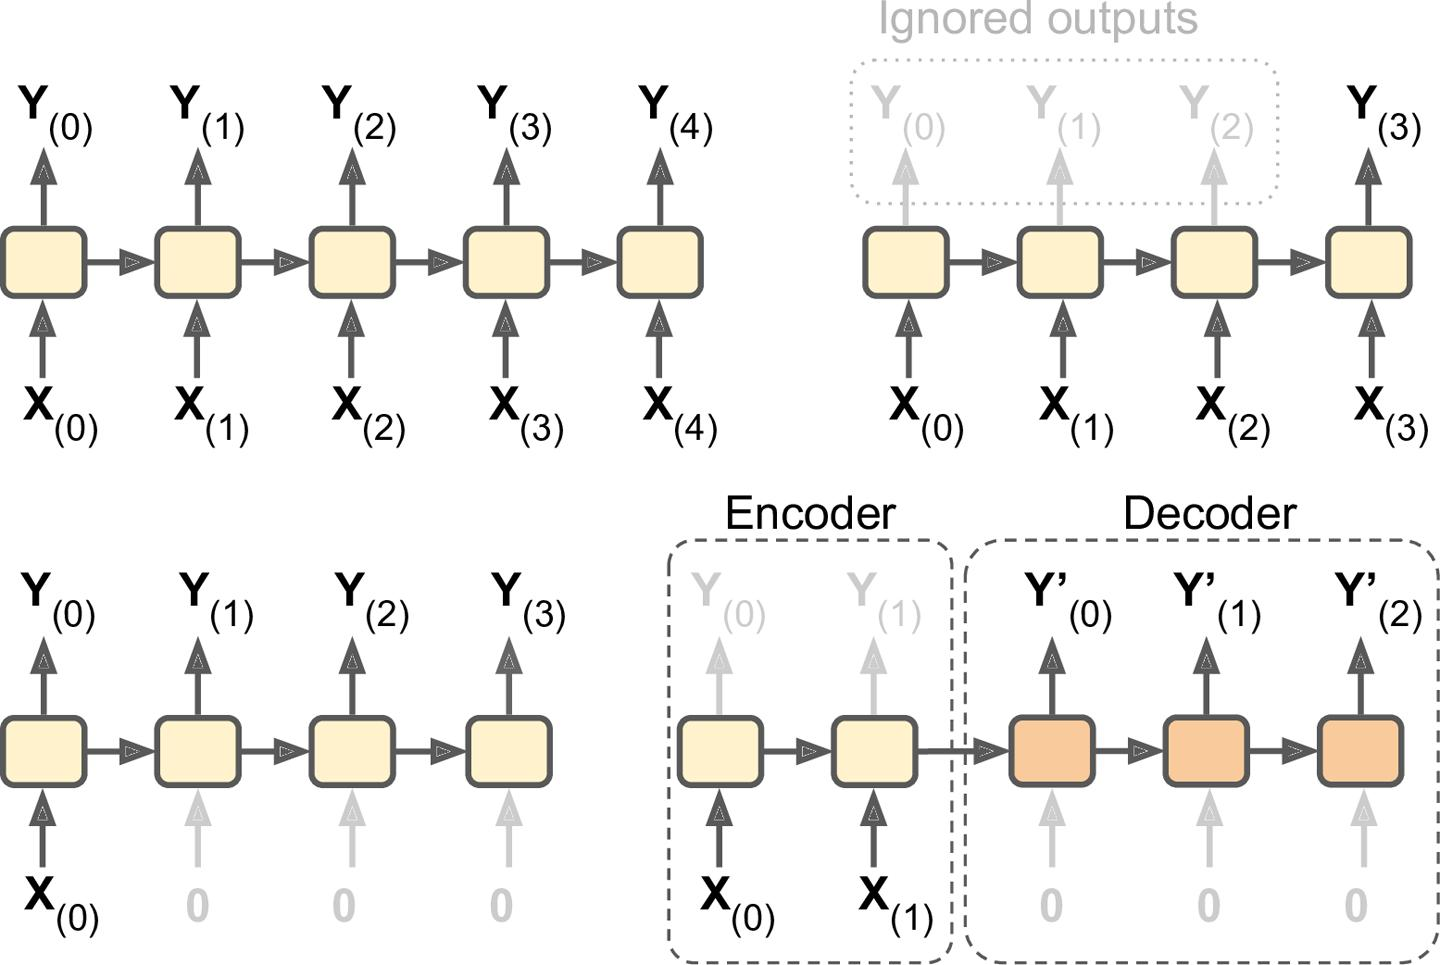

In [7]:
show_image('./images/img2764.jpg')

- Sequence to Sequence (top left)
- Sequence to Vector (top right)
- Vector to Sequence (bottom left)
- Delayed Sequence to Sequence (bottom right)

In [8]:
reset_graph()

`static_rnn()` function creates an unrolled RNN network by chaining cells.

`static_rnn()` function receives the cell factory, input tensors and data type
which is used to create initial state of the matrix. `static_rnn()` function then
calls the `__call__()` method of the cell factory once per input to create two copies
of the cell (each containing a layer of five recurrent neurons) since we
have only two inputs X0 and X1.

These copied cells share weights and biases.

`static_rnn()` function returns two objects
- The first object is a list containing the output tensors for each time step.
- The second object is the final state of the network (which equals to the final output if we use basic cell)

In [9]:
X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

# Here we create a basic RNN cell which is a factory used to create copies of the cell to build the unrolled RNN
basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.nn.static_rnn(cell=basic_cell, inputs=[X0, X1], dtype=tf.float32)

Y0, Y1 = output_seqs

In [10]:
basic_cell

In [11]:
output_seqs

[<tf.Tensor 'rnn/rnn/basic_rnn_cell/Tanh:0' shape=(?, 5) dtype=float32>,
 <tf.Tensor 'rnn/rnn/basic_rnn_cell/Tanh_1:0' shape=(?, 5) dtype=float32>]

In [12]:
states

<tf.Tensor 'rnn/rnn/basic_rnn_cell/Tanh_1:0' shape=(?, 5) dtype=float32>

In [13]:
Y0

<tf.Tensor 'rnn/rnn/basic_rnn_cell/Tanh:0' shape=(?, 5) dtype=float32>

In [14]:
Y1

<tf.Tensor 'rnn/rnn/basic_rnn_cell/Tanh_1:0' shape=(?, 5) dtype=float32>

In [15]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    states_val = sess.run(states, feed_dict={X0: X0_batch, X1: X1_batch})
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [16]:
Y0_val

array([[ 0.30741334, -0.32884315, -0.65428472, -0.93850589,  0.52089024],
       [ 0.99122757, -0.95425421, -0.75180793, -0.99952078,  0.98202348],
       [ 0.99992681, -0.99783254, -0.82473528, -0.9999963 ,  0.99947774],
       [ 0.99677098, -0.68750614,  0.84199691,  0.93039107,  0.8120684 ]], dtype=float32)

In [17]:
Y1_val

array([[ 0.99998885, -0.99976051, -0.06679298, -0.99998039,  0.99982214],
       [-0.65249437, -0.51520866, -0.37968954, -0.59225935, -0.08968385],
       [ 0.99862403, -0.99715197, -0.03308626, -0.99915648,  0.99329019],
       [ 0.99681675, -0.95981938,  0.39660636, -0.83076048,  0.79671967]], dtype=float32)

In [18]:
states_val

array([[ 0.99998885, -0.99976051, -0.06679298, -0.99998039,  0.99982214],
       [-0.65249437, -0.51520866, -0.37968954, -0.59225935, -0.08968385],
       [ 0.99862403, -0.99715197, -0.03308626, -0.99915648,  0.99329019],
       [ 0.99681675, -0.95981938,  0.39660636, -0.83076048,  0.79671967]], dtype=float32)

In [19]:
show_graph(tf.get_default_graph())

#### Packing Sequences

In [20]:
reset_graph()

If we have a lot of time steps it'll be inconvenient to define a lot of input placeholders and output tensors.
Besides, at execution time, we've to feed a lot of input placeholders and manipulate a lot of outputs as well.

To resolve the above problem, we can define the input tensor X with the shape of `[None, n_steps, n_inputs]`.
Then, we extract the list of input sequences for each time step.
`X_seqs` is a list of n_steps tensors of shape `[None, n_inputs]` (the first dimension is the mini-batch size). 
In order to do that, we need to swap the first two dimensions of `X` so that n_steps becomes the first dimension
(using `tf.transpose()` function). After that, we extract a list of tensors along the first dimension using 
`tf.unstack()` function. Finally, we merge all the output tensors into a single tensor using `tf.stack()` function.
Again, we swap the first two dimensions to get the final output tensor of shape `[None, n_steps, n_neurons]`.

In [21]:
n_steps = 2
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
X_seqs = tf.unstack(tf.transpose(X, perm=[1, 0, 2]))
basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.nn.static_rnn(basic_cell, X_seqs, dtype=tf.float32)
outputs = tf.transpose(tf.stack(output_seqs), perm=[1, 0, 2])

# A single tensor containing all the mini-batch sequences
X_batch = np.array([
        # t = 0      t = 1 
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])


with tf.Session() as sess:
    tf.global_variables_initializer().run()
    X_seqs_eval = sess.run(X_seqs, feed_dict={X: X_batch})
    outputs_val = sess.run(outputs, feed_dict={X: X_batch})
    states_val = sess.run(states, feed_dict={X: X_batch})

In [22]:
X_batch.shape

(4, 2, 3)

In [23]:
len(X_seqs)

2

In [24]:
X_seqs_eval # We split the input by each time step and append the result into a list

[array([[ 0.,  1.,  2.],
        [ 3.,  4.,  5.],
        [ 6.,  7.,  8.],
        [ 9.,  0.,  1.]], dtype=float32), array([[ 9.,  8.,  7.],
        [ 0.,  0.,  0.],
        [ 6.,  5.,  4.],
        [ 3.,  2.,  1.]], dtype=float32)]

In [25]:
outputs_val

array([[[-0.45652324, -0.68064123,  0.40938237,  0.63104504, -0.45732826],
        [-0.94288003, -0.99988687,  0.94055814,  0.99999851, -0.9999997 ]],

       [[-0.80015349, -0.99218267,  0.78177971,  0.9971031 , -0.99646091],
        [-0.63711601,  0.11300932,  0.5798437 ,  0.43105593, -0.63716984]],

       [[-0.93605185, -0.99983788,  0.93088669,  0.99998152, -0.99998295],
        [-0.9165386 , -0.99456042,  0.89605415,  0.99987197, -0.99997509]],

       [[ 0.99273688, -0.99819332, -0.55543643,  0.9989031 , -0.9953323 ],
        [-0.02746334, -0.73191994,  0.7827872 ,  0.95256817, -0.97817713]]], dtype=float32)

In [26]:
# We get a single output tensor for all instances, all time steps and all neurons
outputs_val.shape

(4, 2, 5)

In [27]:
# The output of the first mini-batch at two time steps.
# Each is a vector of size 5 as we have 5 recurrent neurons.
outputs_val[0]

array([[-0.45652324, -0.68064123,  0.40938237,  0.63104504, -0.45732826],
       [-0.94288003, -0.99988687,  0.94055814,  0.99999851, -0.9999997 ]], dtype=float32)

In [28]:
# The output of all mini-batches at each time step.
np.transpose(outputs_val, axes=[1, 0, 2])

array([[[-0.45652324, -0.68064123,  0.40938237,  0.63104504, -0.45732826],
        [-0.80015349, -0.99218267,  0.78177971,  0.9971031 , -0.99646091],
        [-0.93605185, -0.99983788,  0.93088669,  0.99998152, -0.99998295],
        [ 0.99273688, -0.99819332, -0.55543643,  0.9989031 , -0.9953323 ]],

       [[-0.94288003, -0.99988687,  0.94055814,  0.99999851, -0.9999997 ],
        [-0.63711601,  0.11300932,  0.5798437 ,  0.43105593, -0.63716984],
        [-0.9165386 , -0.99456042,  0.89605415,  0.99987197, -0.99997509],
        [-0.02746334, -0.73191994,  0.7827872 ,  0.95256817, -0.97817713]]], dtype=float32)

In [29]:
states_val

array([[-0.94288003, -0.99988687,  0.94055814,  0.99999851, -0.9999997 ],
       [-0.63711601,  0.11300932,  0.5798437 ,  0.43105593, -0.63716984],
       [-0.9165386 , -0.99456042,  0.89605415,  0.99987197, -0.99997509],
       [-0.02746334, -0.73191994,  0.7827872 ,  0.95256817, -0.97817713]], dtype=float32)

One downside of the above approach is that it builds a graph containing one cell per time step. If there're a lot of time steps, the graph would look ugly. Moreover, with a large graph, we may run out of memory during backpropgation since it must store all tensor values during the forward pass so that it can use them to compute gradients during reverse pass. To solve that problem, we can use `dynamic_rnn` function.

In [30]:
show_graph(tf.get_default_graph())

### Dynamic unrolling through time

In [31]:
reset_graph()

# The dynamic_rnn function uses Tensorflow while_loop operation to run over the cell
# an appropriate number of times. We can set swap_memory to True during backpropagation
# to swap GPU's memory to CPU's memory to avoid out-of-memory errors.
#
# dynamic_rnn function accepts a single tensor for all inputs at every time step
# with the shape of [None, n_steps, n_inputs], and returns a single output tensor
# of shape [None, n_steps, n_neurons]
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

X_batch = np.array([
        [[0, 1, 2], [9, 8, 7]], 
        [[3, 4, 5], [0, 0, 0]], 
        [[6, 7, 8], [6, 5, 4]],
        [[9, 0, 1], [3, 2, 1]],
    ])

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    outputs_val = sess.run(outputs, feed_dict={X: X_batch})
    states_val = sess.run(states, feed_dict={X: X_batch})

In [32]:
outputs_val

array([[[-0.0948875 , -0.78635412, -0.75976855,  0.81456447, -0.86596668],
        [-0.99999809, -0.99989897, -0.99999422,  0.99959809, -0.4085584 ]],

       [[-0.98823678, -0.99379838, -0.99848306,  0.99407357, -0.9553898 ],
        [ 0.21658944, -0.20340651,  0.02591269,  0.44528607, -0.40116802]],

       [[-0.99991536, -0.99983823, -0.99999166,  0.99982721, -0.98561245],
        [-0.99981058, -0.99268609, -0.99952865,  0.99385983, -0.25559649]],

       [[-0.99883717,  0.84198505, -0.97267133, -0.86984301,  0.99912703],
        [-0.97511095, -0.34840977, -0.92128128,  0.39821982,  0.27953893]]], dtype=float32)

In [33]:
states_val

array([[-0.99999809, -0.99989897, -0.99999422,  0.99959809, -0.4085584 ],
       [ 0.21658944, -0.20340651,  0.02591269,  0.44528607, -0.40116802],
       [-0.99981058, -0.99268609, -0.99952865,  0.99385983, -0.25559649],
       [-0.97511095, -0.34840977, -0.92128128,  0.39821982,  0.27953893]], dtype=float32)

In [34]:
show_graph(tf.get_default_graph())

### Handling variable length input sequences

In [35]:
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)

# We can use variable length rather than fixed length for the input sequences by setting the sequence_length
# parameter of the dynamic_rnn function. It's a 1D tensor (vector) containing the length of the input sequence
# for each instance.
seq_length = tf.placeholder(tf.int32, [None])
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32, sequence_length=seq_length)

In [36]:
# The second input sequence contains only one set of inputs (1 vector) instead of two.
# Therefore, it must be padded with a zero vector in order to fit in the input tensor X
X_batch = np.array([
        # t=0       t=1
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2 (padded with zero vector)
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

seq_length_batch = np.array([2, 1, 2, 2])

In [37]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    outputs_val, states_val = sess.run([outputs, states], feed_dict={X: X_batch, seq_length: seq_length_batch})

In [38]:
# The RNN outputs zero vectors for every time step past the input sequence length
# Look at the second instance's output for the second time step (t = 1)
# In this case output at the time step (t = 0) will be the final state of the
# second instance's output.
outputs_val

array([[[ 0.73155707,  0.34835717,  0.50581998, -0.22882833, -0.44022718],
        [-0.61832315,  0.99999994,  0.86584806,  0.97933769,  0.9902246 ]],

       [[ 0.8438704 ,  0.99697548,  0.84789461,  0.4303219 ,  0.09275495],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 0.91159219,  0.99999052,  0.95954454,  0.81892216,  0.57740247],
        [-0.77545464,  0.99987745,  0.97847283,  0.73172009,  0.888776  ]],

       [[-0.99952269,  0.99977839,  0.59744656,  0.99309695,  0.99847412],
        [-0.62120003,  0.54000849,  0.96938425,  0.19893228,  0.1944804 ]]], dtype=float32)

In [39]:
# The states tensor contains the final state of each cell (excluding the zero vectors)
states_val

array([[-0.61832315,  0.99999994,  0.86584806,  0.97933769,  0.9902246 ],
       [ 0.8438704 ,  0.99697548,  0.84789461,  0.4303219 ,  0.09275495],
       [-0.77545464,  0.99987745,  0.97847283,  0.73172009,  0.888776  ],
       [-0.62120003,  0.54000849,  0.96938425,  0.19893228,  0.1944804 ]], dtype=float32)

If the output sequences have variable lengths and we know in advance what length each sequence will have, then we can set the sequence_length parameter as above. However, in general this will not be possible (for example, the length of the translated sentence will be different from the length of the input sentence). In this case, a solution is to define a special output called an **end-of-sequence token (EOS token)**. Any output past the EOS should be ignored (we will do this later in this notebook)

### Training a sequence classifier

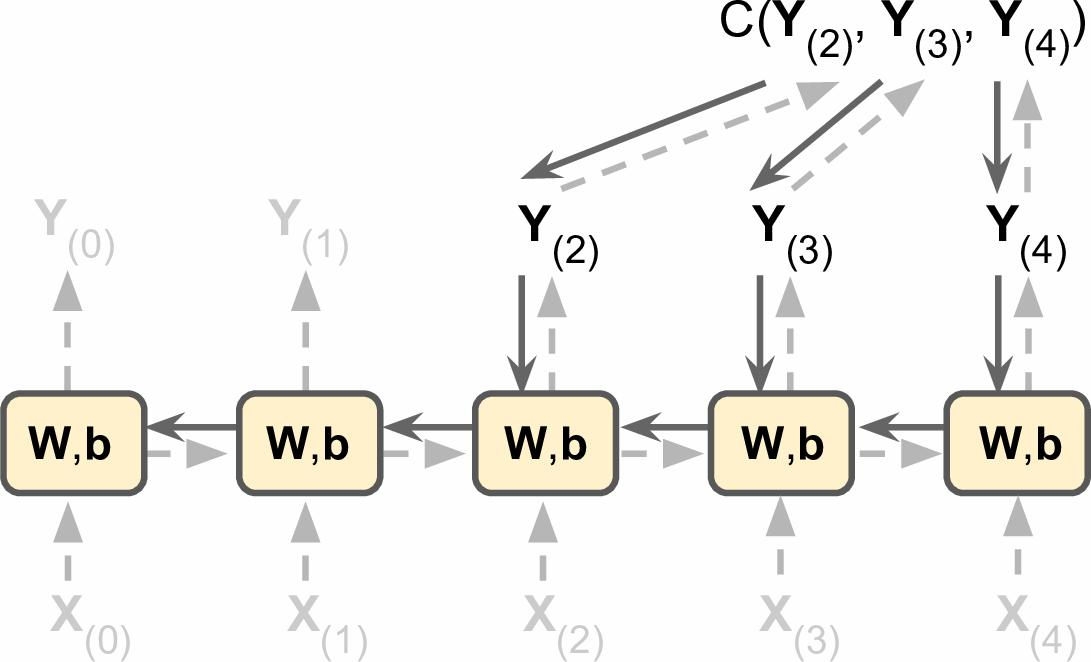

In [40]:
show_image('./images/img2772.jpg')

To train an RNN, we first need to unroll it through time (like what we did in the previous section). Then, we simply use regular backpropagation algorithm like a normal deep neural network. This method is called **backpropagation through time - BPTT**

Like a regular backpropagation, we need to perform two passes through the network: **forward pass** and **reverse (backward) pass**.

In **forward pass**, we go through the *unrolled* network in the forward order to calculate output sequence. This output sequence is then evaluated using a cost function $C(Y_{(t_{min})}, Y_{(t_{min}+1)},...,Y_{(t_{max})})$ where $t_{min}$ and $t_{max}$ are the first and the last output time steps (excluding ignored outputs).

In **backward pass**, the gradients of that cost function are propagated backward through the unrolled network and model parameters are updated using the gradients computed during BPTT. Note that the gradients flow backward through all outputs *used by the cost function*. Moreover, since **W** and **b** are the same for all time steps, backpropagation will take care of that for us.

In the following example, we're going to build a simple image classification using MNIST dataset. **Each image represents a sequence of 28 rows of 28 pixels**. Our RNN cell contains 150 recurrent neurons. The network is followed by a fully connected layers (10 neurons) and a softmax layer.

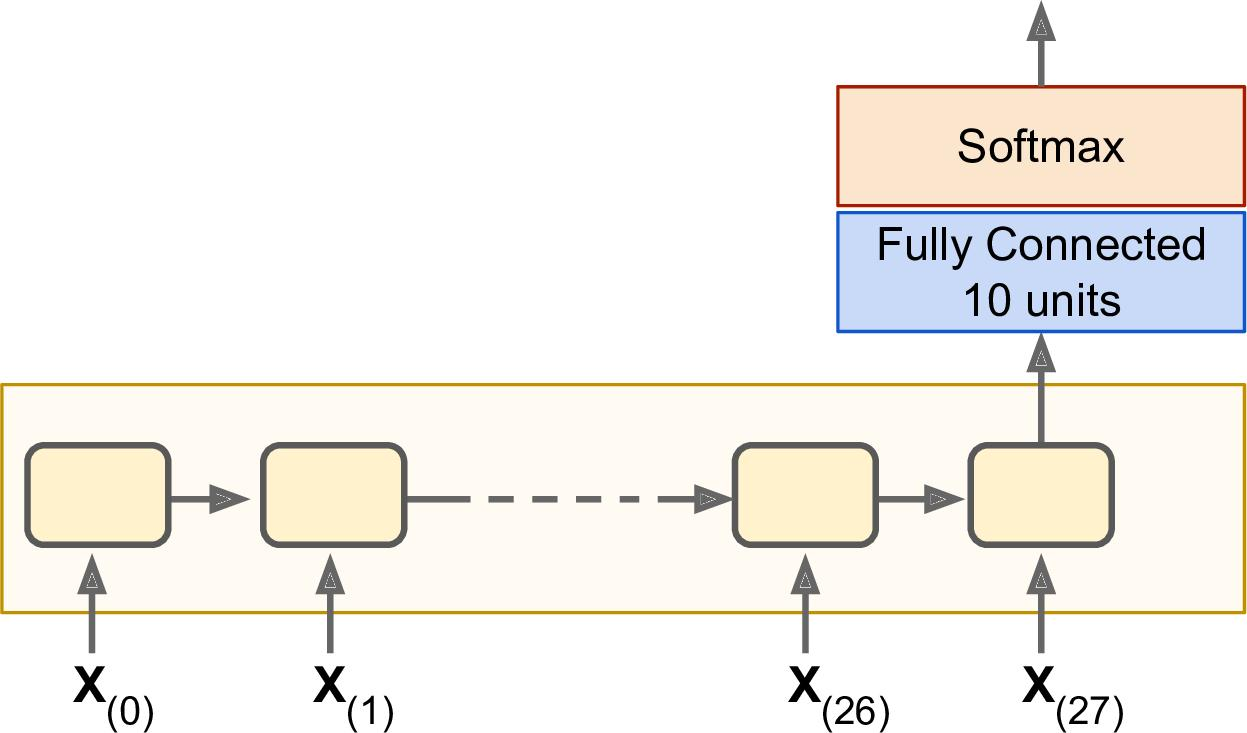

In [41]:
show_image('./images/img2777.jpg')

In [42]:
reset_graph()

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

learning_rate = 1e-3

# We need to reshape the input X in order to feed to the RNN
X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

# To use He initialization, we need to wrap the construction code inside a variable scope
he_init = tf.contrib.layers.variance_scaling_initializer()
with tf.variable_scope("rnn", initializer=he_init):
    basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
    outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

# The output of the last time step will be passed to the fully connected layer of 10 neurons.
logits = tf.layers.dense(states, n_outputs)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("Epoch:", epoch, "Train:", acc_train)
    # Evaluate the test accuracy after the last epoch (for testing purpose)
    acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
    print("Test:", acc_test)

Epoch: 0 Train: 0.953333
Epoch: 1 Train: 0.946667
Epoch: 2 Train: 0.953333
Epoch: 3 Train: 0.973333
Epoch: 4 Train: 0.973333
Epoch: 5 Train: 0.98
Epoch: 6 Train: 0.986667
Epoch: 7 Train: 0.973333
Epoch: 8 Train: 0.98
Epoch: 9 Train: 0.973333
Test: 0.9719


In [43]:
show_graph(tf.get_default_graph())

To improve the above network, we may tune its hyperparameters, use He initialization, train longer, or apply regularization (dropout for example).

### Predict time series

One of important applications of RNN is predicting time series such as stock prices, temparature, wave patterns, and weather forecast.

In the following example, we'll illustrate a process of predicting wave patterns. Each training instance is a **randomly selected sequence** of 20 consecutive values from the time series. The target sequence is the same as the input sequence but shifted by one time step into the future. Let's plot something:

In [44]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

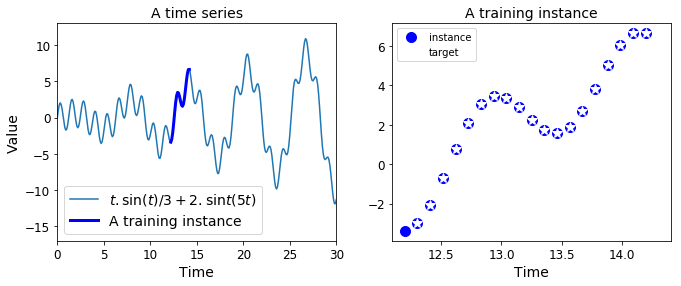

In [45]:
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))
n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plt.title("A time series", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sint(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.show()
plt.clf()

In [46]:
X_batch, y_batch = next_batch(1, n_steps)

In [47]:
X_batch.shape

(1, 20, 1)

In [48]:
y_batch.shape

(1, 20, 1)

In [49]:
np.c_[X_batch[0], y_batch[0]]

array([[ -2.39551665e+00,  -2.64603149e+00],
       [ -2.64603149e+00,  -2.40227225e+00],
       [ -2.40227225e+00,  -1.68134526e+00],
       [ -1.68134526e+00,  -6.14561285e-01],
       [ -6.14561285e-01,   5.84293607e-01],
       [  5.84293607e-01,   1.67084254e+00],
       [  1.67084254e+00,   2.42945897e+00],
       [  2.42945897e+00,   2.72554065e+00],
       [  2.72554065e+00,   2.53792320e+00],
       [  2.53792320e+00,   1.96350308e+00],
       [  1.96350308e+00,   1.19294411e+00],
       [  1.19294411e+00,   4.63421808e-01],
       [  4.63421808e-01,  -1.83139986e-05],
       [ -1.83139986e-05,  -4.01241211e-02],
       [ -4.01241211e-02,   3.93512896e-01],
       [  3.93512896e-01,   1.23158805e+00],
       [  1.23158805e+00,   2.30155199e+00],
       [  2.30155199e+00,   3.36939148e+00],
       [  3.36939148e+00,   4.19649923e+00],
       [  4.19649923e+00,   4.59771458e+00]])

Our RNN will contain 100 recurrent neurons and we'll unroll it over 20 time steps (because each training instance is 20 inputs long). Each input contains only one feature value (the value at a given time). The targets are also sequences of 20 inputs, each contains a single value.

In this demo, our instances have only one input feature. It might not be the case for real-life problems. For example, if we're trying to predict stock prices, we would have a lot of input features at each time step such as price, rating, etc.

In [50]:
n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])
cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [51]:
outputs.shape

TensorShape([Dimension(None), Dimension(20), Dimension(100)])

At each time step, we have an output vector of size 100. However, we only want a single output value at each time step. One way to do that it to wrap the cell in an `OutputProjectionWrapper` cell wrapper. The wrapper cell proxies all method calls to an underlying cell, but it also adds some functionality. `OutputProjectionWrapper` adds a fully connected layer of linear neurons (neurons without activation function) on top of each output. All these fully connected layers share the same (trainable) weights and bias terms.

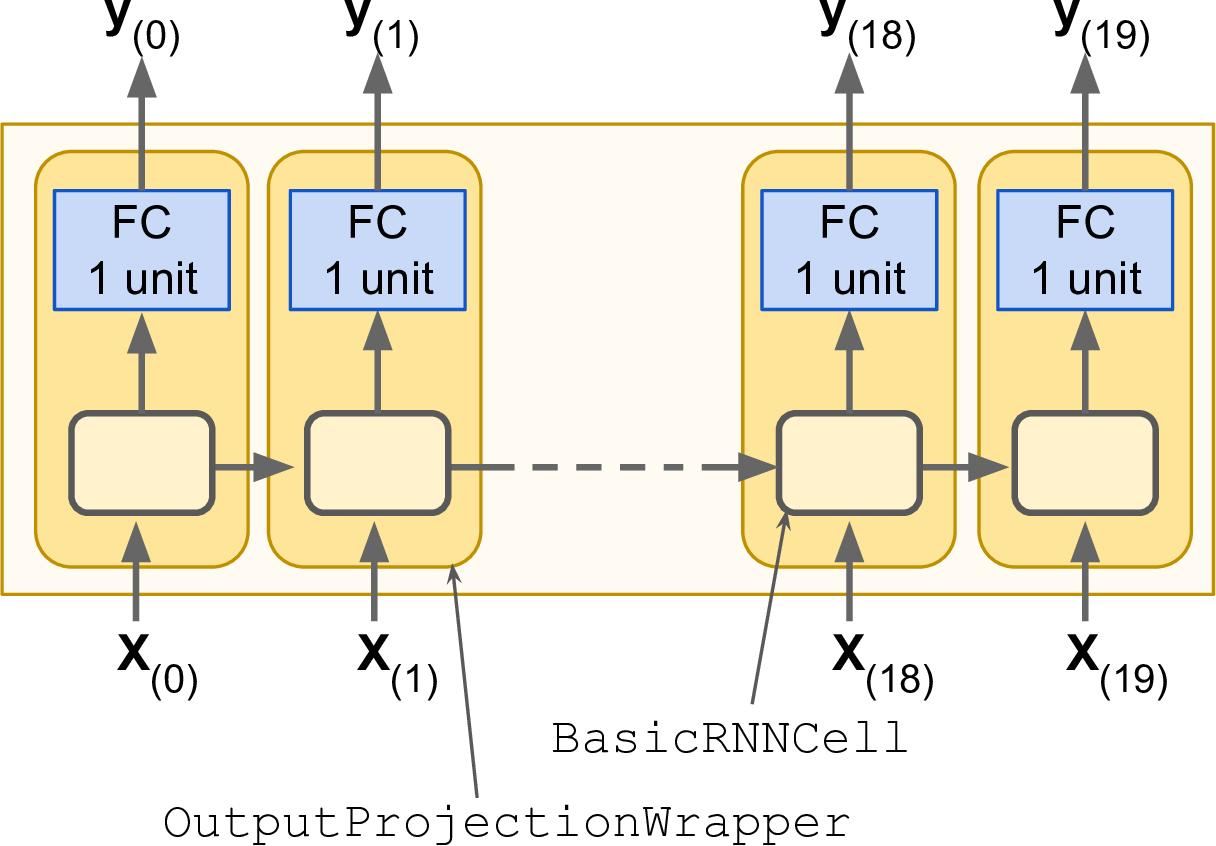

In [52]:
show_image('./images/img2791.jpg')

In [53]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1
learning_rate = 1e-3

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

# Reduce the output size to 1 rather than 100 (for 100 recurrent neurons)
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)

outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

loss = tf.reduce_mean(tf.square(outputs - y)) # Use MSE as cost function

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

batch_size = 50
n_iterations = 1500
saver = tf.train.Saver()

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    saver.save(sess, './models/time_series/time_series_model')

0 	MSE: 18.9177
100 	MSE: 0.762551
200 	MSE: 0.290907
300 	MSE: 0.149525
400 	MSE: 0.0772763
500 	MSE: 0.0665644
600 	MSE: 0.0636215
700 	MSE: 0.0559812
800 	MSE: 0.0554487
900 	MSE: 0.0529518
1000 	MSE: 0.0534466
1100 	MSE: 0.051972
1200 	MSE: 0.0442769
1300 	MSE: 0.0547834
1400 	MSE: 0.0466028


In [54]:
with tf.Session() as sess:
    saver.restore(sess, './models/time_series/time_series_model')
    
    t_sample = np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs))
    X_new = time_series(t_sample)
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./models/time_series/time_series_model


In [55]:
t_sample

array([[[ 12.2  ],
        [ 12.305],
        [ 12.41 ],
        [ 12.515],
        [ 12.62 ],
        [ 12.725],
        [ 12.83 ],
        [ 12.935],
        [ 13.04 ],
        [ 13.145],
        [ 13.25 ],
        [ 13.355],
        [ 13.46 ],
        [ 13.565],
        [ 13.67 ],
        [ 13.775],
        [ 13.88 ],
        [ 13.985],
        [ 14.09 ],
        [ 14.195]]])

In [56]:
X_new

array([[[-3.38903462],
        [-2.99062806],
        [-2.05341138],
        [-0.72228309],
        [ 0.75538291],
        [ 2.09516406],
        [ 3.05094764],
        [ 3.47993654],
        [ 3.37980751],
        [ 2.88802793],
        [ 2.24353023],
        [ 1.7210823 ],
        [ 1.55604639],
        [ 1.87980783],
        [ 2.68328027],
        [ 3.81833127],
        [ 5.03675731],
        [ 6.05632222],
        [ 6.63608254],
        [ 6.64072041]]])

In [57]:
y_pred

array([[[-3.42637658],
        [-2.46367216],
        [-1.15637207],
        [ 0.76617211],
        [ 2.29781222],
        [ 3.12525225],
        [ 3.4899745 ],
        [ 3.33646941],
        [ 2.82800984],
        [ 2.24254656],
        [ 1.71146703],
        [ 1.62021911],
        [ 2.00660276],
        [ 2.79940104],
        [ 3.91245008],
        [ 5.18602514],
        [ 6.16892099],
        [ 6.69519091],
        [ 6.66508675],
        [ 6.10952806]]], dtype=float32)

Let's plot the predictions of the trained model:

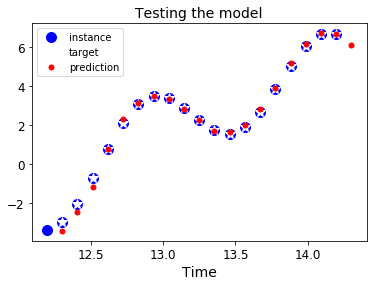

In [58]:
# A bit overfitting?
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0, :, 0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.show()
plt.clf()

`OutputProjectionWrapper` is a solution to reduce the dimensionality of the RNN's output sequences down to 1 (or any other sizes) value per time step; however, it's not efficient.

Another way to tackle the above process is reshaping (stacking vertically) RNN outputs from `[batch_size, n_steps, n_neurons]` to `[batch_size * n_steps, n_neurons]`, then applying a single fully connected layer (rather than a separated fully connected layer for each output like `OutputProjectionWrapper`) with appropriate output size. The dense layer results in an output tensor of shape `[batch_size * n_steps, n_outputs]`. We can then reshape (unstacking) this tensor to `[batch_size, n_steps, n_outputs]`. These operations are illustrated in the following figure:

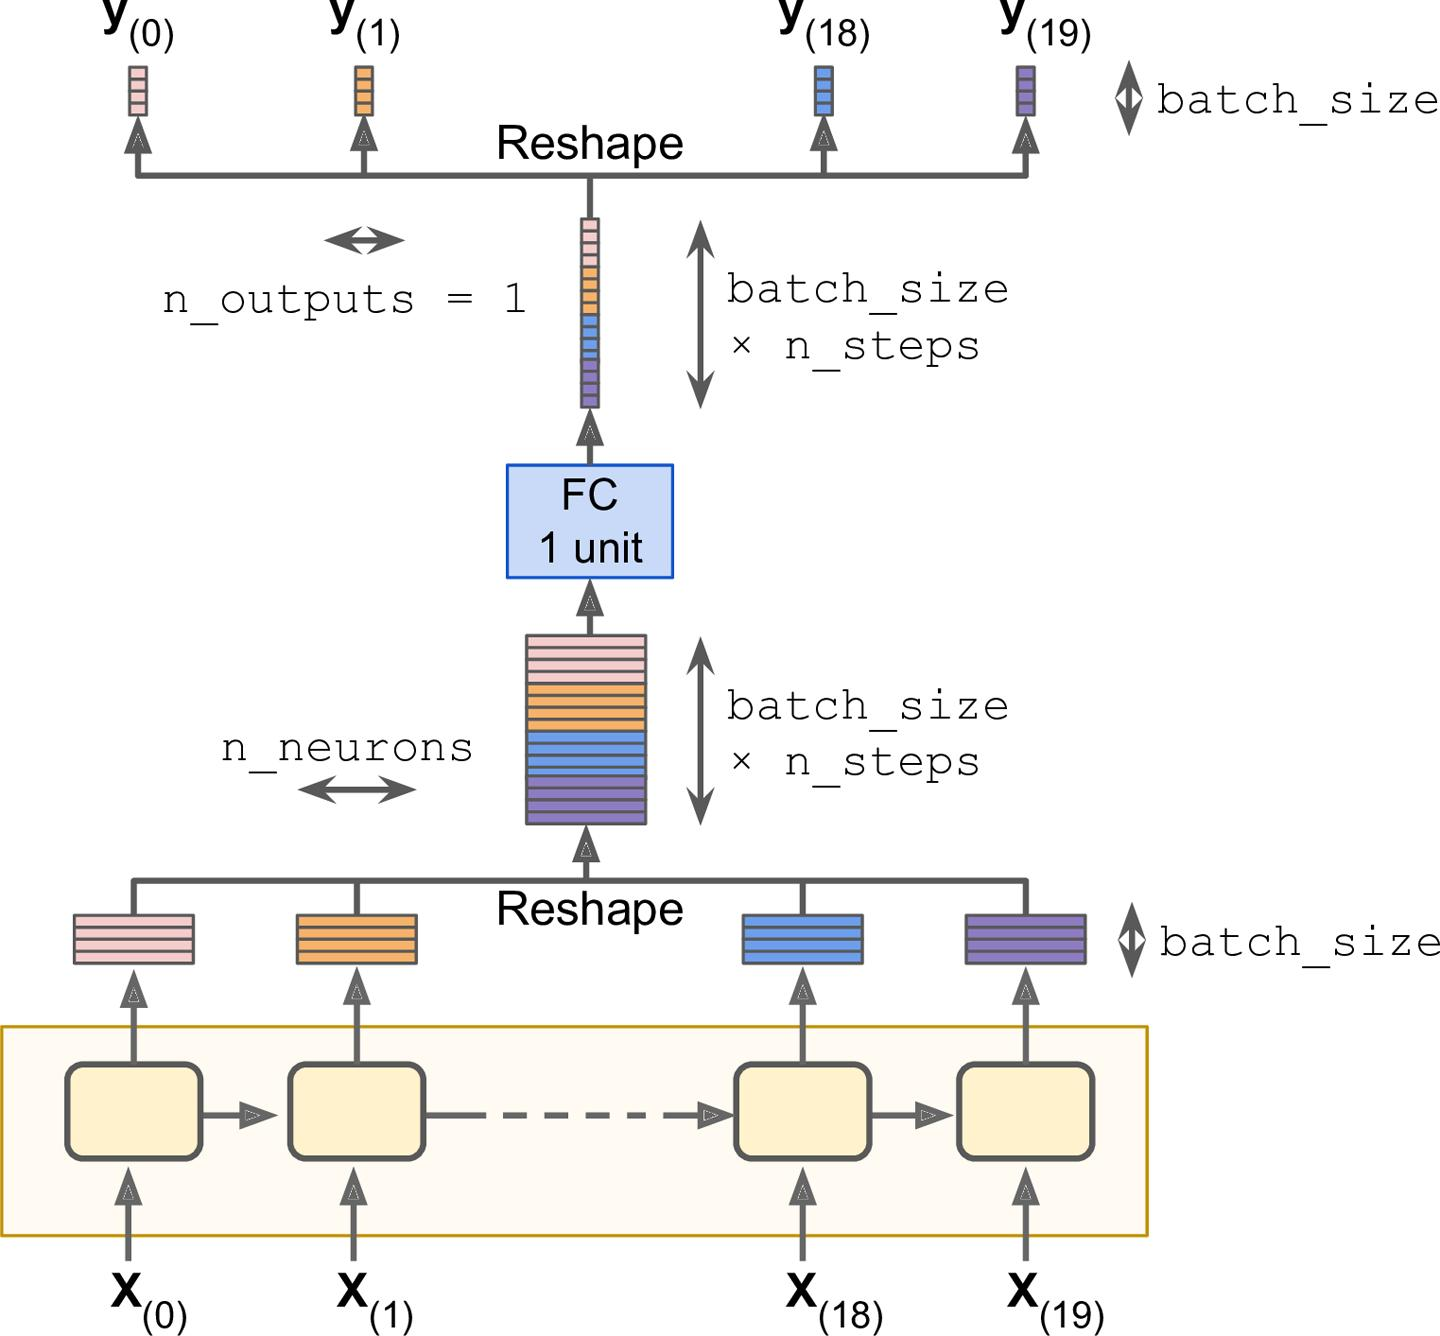

In [59]:
show_image('./images/img2802.jpg')

In [60]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

stacked_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs_dense = tf.layers.dense(stacked_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs_dense, [-1, n_steps, n_outputs])

learning_rate = 1e-3
loss = tf.reduce_mean(tf.square(outputs - y))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

batch_size = 50
n_iterations = 1500
saver = tf.train.Saver()

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    saver.save(sess, './models/time_series/time_series_model')

0 	MSE: 10.1622
100 	MSE: 0.406083
200 	MSE: 0.116547
300 	MSE: 0.0686967
400 	MSE: 0.0689586
500 	MSE: 0.0625274
600 	MSE: 0.056175
700 	MSE: 0.0507173
800 	MSE: 0.0516515
900 	MSE: 0.0502068
1000 	MSE: 0.0497242
1100 	MSE: 0.0506494
1200 	MSE: 0.0413749
1300 	MSE: 0.0501782
1400 	MSE: 0.0440728


### Creative RNN

We had a model that can predict the future, we can use it to generate some creative sequences.

We can provide the model a seed sequence containing `n_steps` values, and use the model to predict next value, append predicted value to the sequences, feed the last `n_steps` values to the model to predict the next value, etc.

In [61]:
with tf.Session() as sess:
    saver.restore(sess, './models/time_series/time_series_model')
    
    sequence = [0.] * n_steps
    for iteration in range(300):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./models/time_series/time_series_model


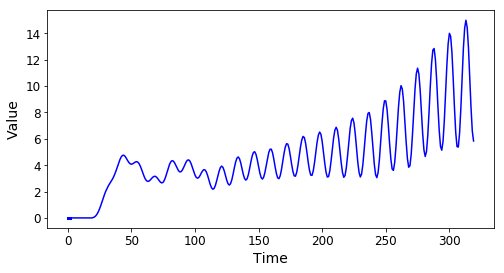

In [62]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(sequence)), sequence, "b-")
plt.plot(t[:n_steps], sequence[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()
plt.clf()

INFO:tensorflow:Restoring parameters from ./models/time_series/time_series_model


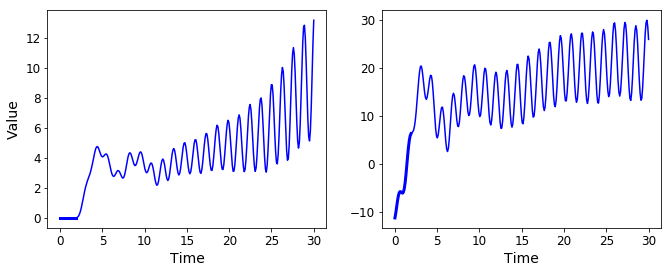

In [63]:
with tf.Session() as sess:
    saver.restore(sess, './models/time_series/time_series_model')

    sequence1 = [0. for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence1[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence1.append(y_pred[0, -1, 0])

    sequence2 = [time_series(i * resolution + t_min + (t_max-t_min/3)) for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence2[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence2.append(y_pred[0, -1, 0])

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(t, sequence1, "b-")
plt.plot(t[:n_steps], sequence1[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.plot(t, sequence2, "b-")
plt.plot(t[:n_steps], sequence2[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.show()
plt.clf()

## Deep RNNs

To construct a deep RNN, we can stack multiple layers of cells. In TensorFlow, we can accomplish that using `MultiRNNCell`.

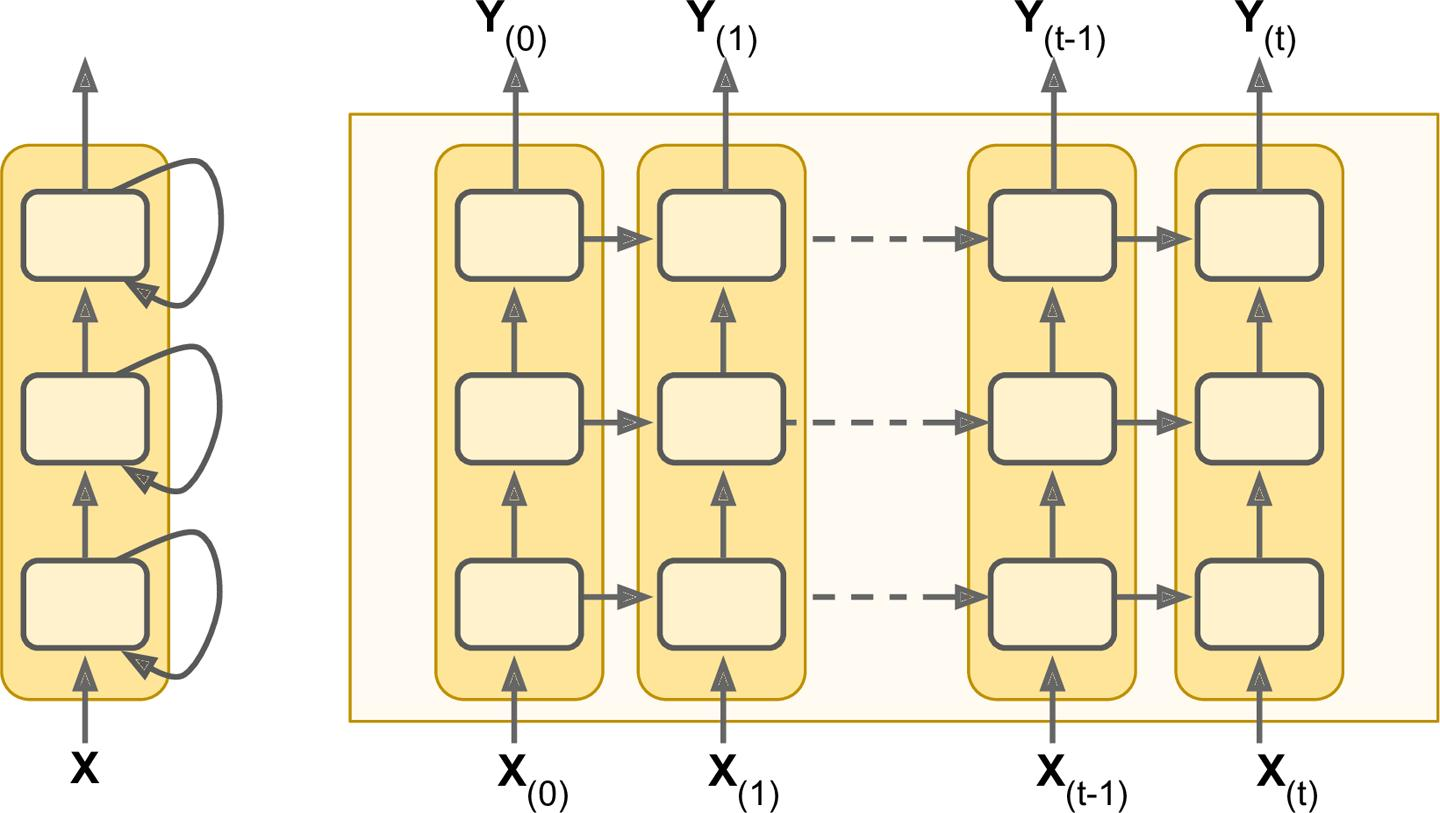

In [64]:
show_image('./images/img2809.jpg')

In [65]:
reset_graph()

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10
n_layers = 2

learning_rate = 1e-3

X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

# Create a list of basic RNN cells. We can use different types of cell with
# different number of recurrent neurons.
cells = [tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
         for layer in range(n_layers)]

# RNN cell composed sequentially of multiple simple cells
multi_layers_cell = tf.nn.rnn_cell.MultiRNNCell(cells)

# The output states variable is a tuple containing one tensor per layer.
# Each of them represents the final state of that layer's cell. Therefore,
# we need to concatenate these tensors before feeding to the fully connected layer.
outputs, states = tf.nn.dynamic_rnn(multi_layers_cell, X, dtype=tf.float32)
states_concat = tf.concat(axis=1, values=states)

print("States length:", len(states_val))
print("States element shape:", states_val[0].shape)
print("Concatenated states shape:", states_concat.shape)

logits = tf.layers.dense(states_concat, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

n_epochs = 3
batch_size = 150

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("Epoch:", epoch, "Train:", acc_train)
    acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
    print("Test:", acc_test)

States length: 4
States element shape: (5,)
Concatenated states shape: (?, 300)
Epoch: 0 Train: 0.94
Epoch: 1 Train: 0.933333
Epoch: 2 Train: 0.993333
Test: 0.9694


### Distributing a deep RNN across multiple GPUs

(later...)

### Applying dropout

When building a very deep RNN, it may end up overfitting the training set. We can use dropout regularization technique to prevent that. We can apply dropout layer before or after RNN. In order to apply dropout between RNN layers, we can use `DropoutWrapper`. Note that dropout regularization should be applied during training process only.

In [66]:
reset_graph()

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10
n_layers = 2

learning_rate = 1e-3

X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

keep_prob = tf.placeholder_with_default(1.0, shape=())

cells = [tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
            for layer in range(n_layers)]

cells_drop = [tf.nn.rnn_cell.DropoutWrapper(cell, input_keep_prob=keep_prob)
              for cell in cells]

multi_layers_cell = tf.nn.rnn_cell.MultiRNNCell(cells_drop)

outputs, states = tf.nn.dynamic_rnn(multi_layers_cell, X, dtype=tf.float32)
states_concat = tf.concat(axis=1, values=states)

logits = tf.layers.dense(states_concat, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

n_epochs = 5
batch_size = 150
train_keep_prob = 0.5
saver = tf.train.Saver()

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch,
                                             keep_prob: train_keep_prob})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("Epoch:", epoch, "Train:", acc_train)
    saver.save(sess, './models/dropout/rnn_with_dropout.ckpt')

Epoch: 0 Train: 0.92
Epoch: 1 Train: 0.986667
Epoch: 2 Train: 0.94
Epoch: 3 Train: 0.973333
Epoch: 4 Train: 0.986667


In [67]:
with tf.Session() as sess:
    # During testing, keep_prob should be kept default to 1.0
    saver.restore(sess, './models/dropout/rnn_with_dropout.ckpt')
    y_pred = sess.run(logits, feed_dict={X: X_test})

INFO:tensorflow:Restoring parameters from ./models/dropout/rnn_with_dropout.ckpt


In [68]:
y_pred = y_pred[:20]
y_pred = [np.argmax(pred) for pred in y_pred]
y_pred

[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 8, 4]

In [69]:
list(y_test[:20])

[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4]

We can apply dropout to the outputs using `output_keep_prob` of `DropoutWrapper`, and apply dropout to the cell's state using `state_keep_prob`.

If the sequence we're training is long, we've to run our RNN over many time steps. As a result, the unrolled RNN is a very deep network, making it harder to train. Deep RNN also suffers from vanishing/exploding gradients problems. Of course, we can apply some techniques like parameter initialization, nonsaturating activation functions, Batch Normalization, fast optimizers, etc. to prevent problems related to gradients. However, a deep network still takes a lot of time to train.

One solution is to unroll the RNN only over a limited number of time steps during training - **truncated backpropagation through time - TBPTT**. However, the model won't be able to learn long-term patterns.

Another problem of long-running RNNs is that the memory of the first inputs gradually fades away. After a number of steps, RNN's state contains nearly no trace of the first inputs. To solve this problem, many types of cell with long-term memory have been developed.

### LSTM Cell

**LSTM - Long Short-Term Memory** can be used as a regular cell; however, its performance is much better, the training process will converge faster, and we're able to detect long-term dependencies in the data.

LSTM cells manage **two state vectors** (they're kept separated by defaut due to performance reasons). We can set `state_is_tuple=False` in `BasicLSTMCell` of TensorFlow to change this behavior.

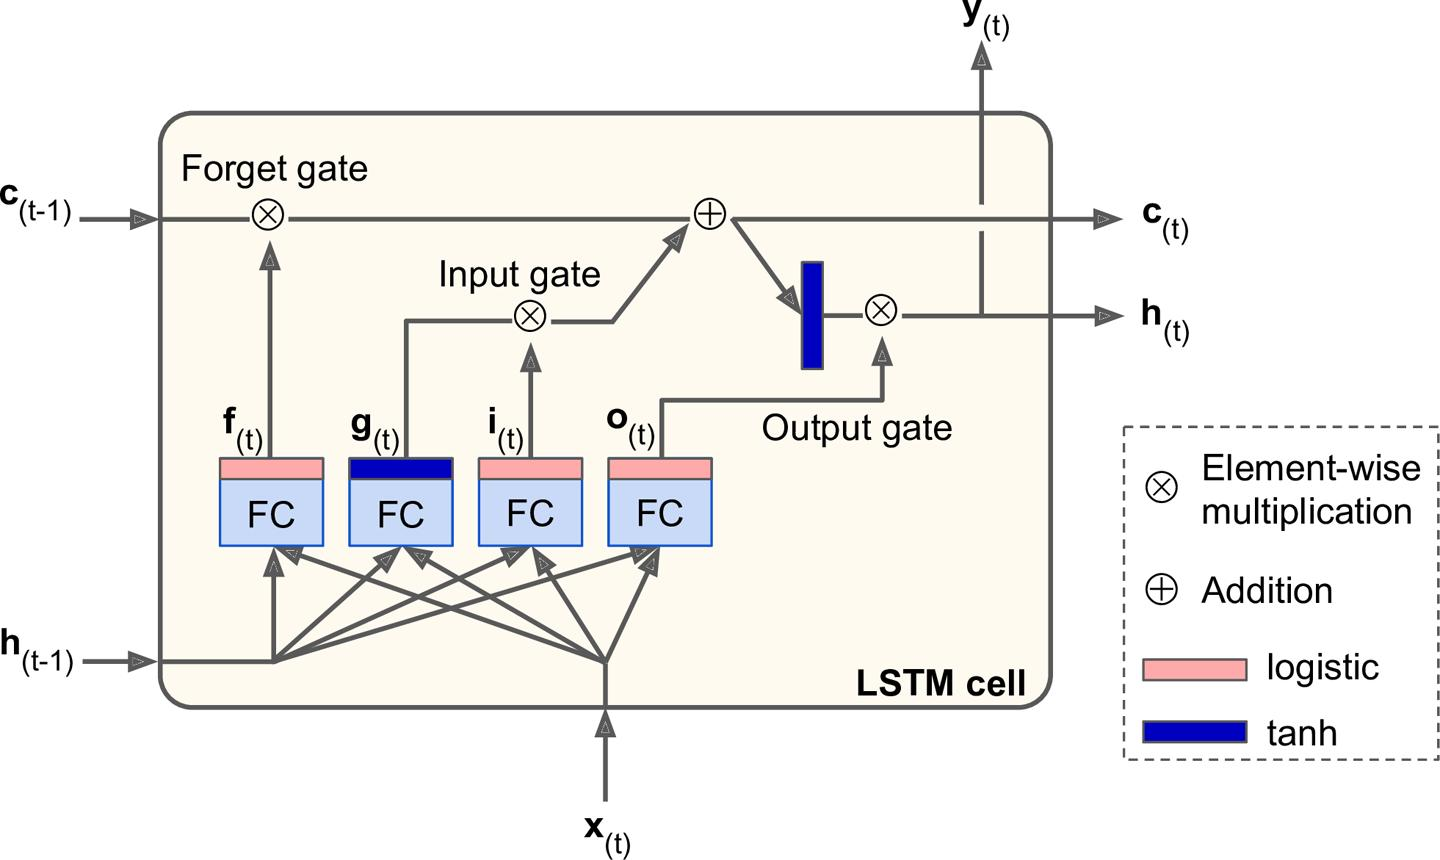

In [70]:
show_image('./images/img2834.jpg')

LSTM cell's state is splitted into two vectors: $\textbf{h}_{(t)}$ and $\textbf{c}_{(t)}$ (**c** for "cell"):

- $\textbf{h}_{(t)}$: short-term state
- $\textbf{c}_{(t)}$: long-term state

A LSTM network can learn what to store in long-term state, what to throw away via forget gate and what to read from.

The **long-term** state $c_{(t-1)}$ first goes through the **forget gate** to drop some memories. Then, some memories (selected by an **input gate**) are added to it via addition operation. The new long-term state $c_{(t)}$ is sent out without any further transformation.

After the addition operation, the long-term state is copied and passed through a **tanh** function, and the result is filtered by the **output gate**. This produces **short-term** state $h_{(t)}$ which is equal to the cell's output for current time step $y_{(t)}$.

Previous short-term state $h_{(t-1)}$ and the input vector $x_{(t)}$ are passed through four different fully connected layers.

- The main layer (which outputs $g_{(t)}$) is responsible to analyze the current input $x_{(t)}$ and the previous short-term state $h_{(t-1)}$. In a basic cell, we'll have this layer only and the output is send straight out to $y_{(t)}$ and $h_{(t)}$. In a LSTM cell, the output of this layer is partially stored in long-term state.

Other three layers are **gate controllers**. Since they use logistic activation function, and their outputs are fed to element-wise multiplication operations. If they output 0, the corresponding gates will be closed and vice versa.

- The **forget gate** (controlled by $f_{(t)}$) controls which parts of the long-term state should be erased.
- The **input gate** (controlled by $i_{(t)}$) controls which parts of $g_{(t)}$ should be added to the long-term state.
- The **output gate** (controlled by $o_{(t)}$) controls which parts of the long-term state should be read and output at this time step.

To sump up, LSTM cell can learn to recognize important input, store it in long-term state, and learn to preserve it for as long as it is needed. That's why this type of cell has good performance in capturing long-term patterns.

LSTM Equations:

$$
\textbf{i}_{(t)} = \sigma\big({\textbf{W}_{xi}}^T . \textbf{x}_{(t)} + {\textbf{W}_{hi}}^T . \textbf{h}_{(t-1)} + \textbf{b}_i\big)
$$

$$
\textbf{h}_{(t)} = \sigma\big({\textbf{W}_{xf}}^T . \textbf{x}_{(t)} + {\textbf{W}_{hf}}^T . \textbf{h}_{(t-1)} + \textbf{b}_f\big)
$$

$$
\textbf{o}_{(t)} = \sigma\big({\textbf{W}_{xo}}^T . \textbf{x}_{(t)} + {\textbf{W}_{ho}}^T . \textbf{h}_{(t-1)} + \textbf{b}_o\big)
$$

$$
\textbf{g}_{(t)} = \tanh\big({\textbf{W}_{xg}}^T . \textbf{x}_{(t)} + {\textbf{W}_{hg}}^T . \textbf{h}_{(t-1)} + \textbf{b}_g\big)
$$

$$
\textbf{c}_{(t)} = \textbf{f}_{(t)}\otimes\textbf{c}_{(t-1)} + \textbf{i}_{(t)}\otimes\textbf{g}_{(t)}
$$

$$
\textbf{y}_{(t)} = \textbf{h}_{(t)} = \textbf{o}_{(t)}\otimes\tanh\big(\textbf{c}_{(t)}\big)
$$

$\textbf{W}_{xi}$, $\textbf{W}_{xf}$, $\textbf{W}_{xo}$, $\textbf{W}_{xg}$ are weights matrices of each of four layers in their connection to the input vector $\textbf{x}_{(t)}$

$\textbf{W}_{hi}$, $\textbf{W}_{hf}$, $\textbf{W}_{ho}$, $\textbf{W}_{hg}$ are weights matrices of each of four layers in their connection to the previous short-term state $\textbf{h}_{(t-1)}$

$\textbf{b}_i$, $\textbf{b}_f$, $\textbf{b}_o$, $\textbf{b}_g$ are bias terms for each layer. In TensorFlow, $\textbf{b}_f$ is a vector full of 1s to prevent forgetting everything at the beginning of training process.

In a basic LSTM cell, the gate controllers only look at the input $x_{(t)}$ and the previous short-term state $h_{(t-1)}$. I would be better if these controllers can peek the long-term state as well.

A variant of LSTM add an extra connection called **Peephole connections**: the previous long-term state $c_{(t-1)}$ is added as an input to the controllers of the forget gate and the input gate, and the current long-term state $c_{(t)}$ is added as input to the controller of the output gate.

To implement this in TensorFlow, we use **LSTMCell** instead of **BasicLSTMCell** with parameter `use_peepholes` be `True`

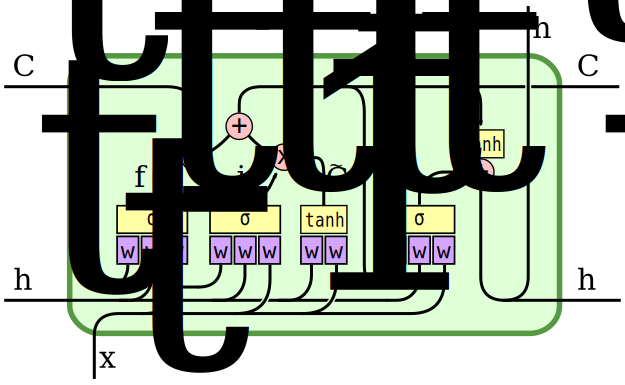

In [71]:
SVG('./images/img2835.svg')

In [72]:
reset_graph()

n_steps = 28
n_inputs = 28
n_outputs = 10
n_layers = 2
n_neurons = 150
learning_rate = 1e-3

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

lstm_cells = [tf.nn.rnn_cell.LSTMCell(n_neurons, use_peepholes=True) 
              for layer in range(n_layers)]
multi_cell = tf.nn.rnn_cell.MultiRNNCell(lstm_cells)

outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
top_layer_h_state = states[-1][1]

logits = tf.layers.dense(top_layer_h_state, n_outputs, name="softmax")
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [73]:
lstm_cells

In [74]:
states

(LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_2:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_4:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_5:0' shape=(?, 150) dtype=float32>))

In [75]:
top_layer_h_state

<tf.Tensor 'rnn/while/Exit_5:0' shape=(?, 150) dtype=float32>

In [76]:
n_epochs = 2
batch_size = 150

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((batch_size, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("Epoch", epoch, "Train accuracy =", acc_train)

Epoch 0 Train accuracy = 0.953333
Epoch 1 Train accuracy = 0.98


In [77]:
basic_lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units=n_neurons)
basic_lstm_cell

### GRU Cell

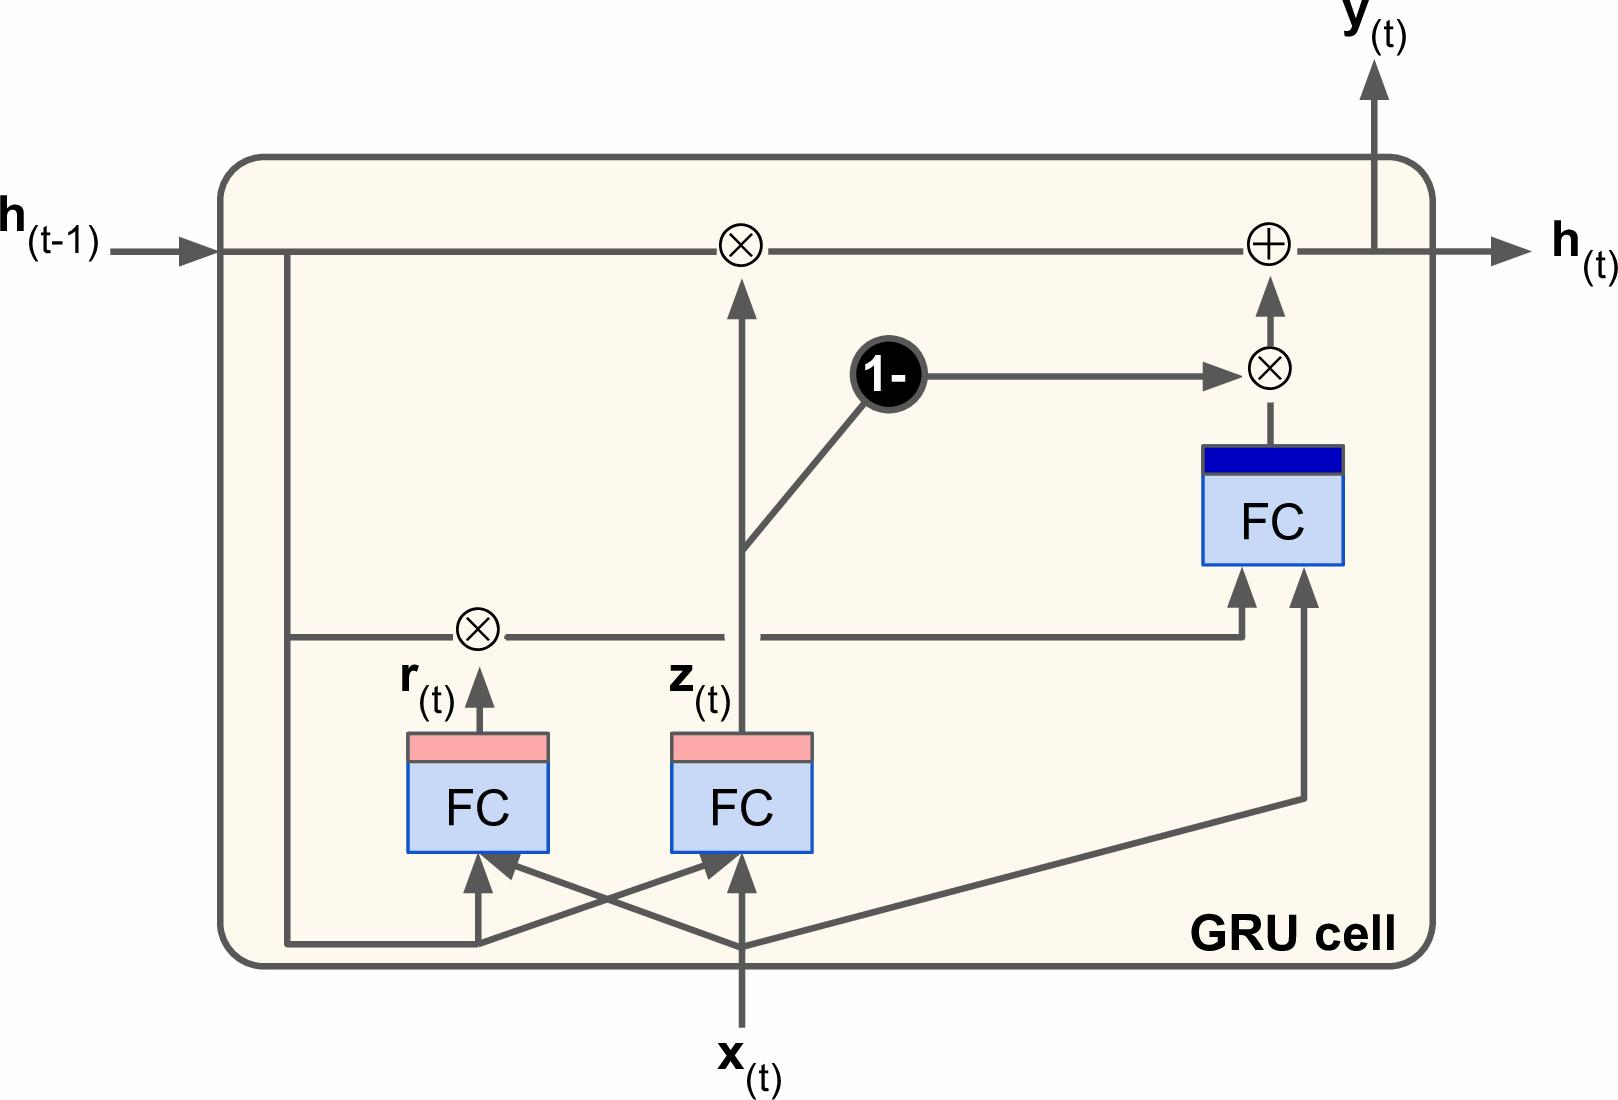

In [78]:
show_image('./images/img2847.jpg')

**GRU - Gated Recurrent Unit** cell is a simplified version of LSTM cell. Main simplifications include:

- Both state vectors $\textbf{h}$ and $\textbf{c}$ are merged into a single vector $\textbf{h}_{(t)}$
- Use single gate controller controls both the forget gate and the input gate. If the gate controller outputs 1, the forget gate is open, the input gate is closed and vice versa
- There is no output gate, the full state vector is output at every time step
- There is a new gate controller that controls which part of the previous state will be shown to the main layer

GRU Equations:

$$
\textbf{z}_{(t)} = \sigma\big({\textbf{W}_{xz}}^T . \textbf{x}_{(t)} + {\textbf{W}_{hz}}^T . \textbf{h}_{(t-1)} + \textbf{b}_z\big)
$$

$$
\textbf{r}_{(t)} = \sigma\big({\textbf{W}_{xr}}^T . \textbf{x}_{(t)} + {\textbf{W}_{hr}}^T . \textbf{h}_{(t-1)} + \textbf{b}_r\big)
$$

$$
\textbf{g}_{(t)} = \tanh\big({\textbf{W}_{xg}}^T . \textbf{x}_{(t)} + {\textbf{W}_{hg}}^T . \big(\textbf{r}_{(t)}\otimes\textbf{h}_{(t-1)}\big) + \textbf{b}_g\big)
$$

$$
\textbf{h}_{(t)} = \textbf{z}_{(t)}\otimes\textbf{h}_{(t-1)} + \big(1 - \textbf{z}_{(t)}\big)\otimes\textbf{g}_{(t)}
$$

In [79]:
reset_graph()

n_steps = 28
n_inputs = 28
n_outputs = 10
n_layers = 2
n_neurons = 150
learning_rate = 1e-3

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

gru_cells = [tf.nn.rnn_cell.GRUCell(n_neurons) for layer in range(n_layers)]
multi_cell = tf.nn.rnn_cell.MultiRNNCell(gru_cells)

outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)

top_layer_h_state = states[-1]

logits = tf.layers.dense(top_layer_h_state, n_outputs, name="softmax")
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

n_epochs = 2
batch_size = 150

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((batch_size, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("Epoch", epoch, "Train accuracy =", acc_train)

Epoch 0 Train accuracy = 0.966667
Epoch 1 Train accuracy = 0.986667


## Natural Language Processing

NLP applications such as **machine translation**, **automatic summarization**, **parsing**, **sentiment analysis**, etc. are all based on RNNs.

Reference:
- https://www.tensorflow.org/tutorials/word2vec
- https://github.com/tensorflow/nmt
- https://github.com/tensorflow/tensorflow/blob/r1.4/tensorflow/examples/tutorials/word2vec/word2vec_basic.py
- https://github.com/tensorflow/models/blob/master/tutorials/embedding/word2vec.py
- https://en.wikipedia.org/wiki/Vector_space_model
- https://en.wikipedia.org/wiki/Latent_semantic_analysis

In the following example, we'll create a simple model used for **machine translation**. This model uses **Sequence to Sequence** RNN architecture.

### Word Embeddings

Before starting, we need to pick a word representation.

A simple solution is using one-hot encoded vector. The idea behind this representation is straightforward. Suppose that our vocabulary contains 100,000 words, then the $n^{th}$ word can be represented as a 100,000-dimensional vector with 1 at the $n^{th}$ position and 0 in other positions. However, this type of representation is not efficient. Generally, we want similar words to have similar representation so that the model may generalize easier what it learns about a word to all similar words. For instance, if we know that *water* and *milk* are close in their representations, and suppose that we have a valid sentence *I drink water*, our model will probably know that *I drink milk* is also a valid sentence.

**Embeddings** is a word representation which represents each word in the vocabulary using a *small and dense vector*. Each embedding is adjusted by neural network during training. During training, backpropagation will automatically move embeddings around. Generally, similar words will cluster close together. For example, embeddings may place along axes that represent gender, singular/plural, adjective/noun, etc.

In [80]:
import os
import errno
import zipfile
from six.moves import urllib

WORDS_PATH = "datasets/words"
WORDS_URL = "http://mattmahoney.net/dc/text8.zip"

def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as e:
        if e.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

def fetch_words_data(words_url=WORDS_URL, words_path=WORDS_PATH):
    os.makedirs(words_path, exist_ok=True)
    zip_path = os.path.join(words_path, "words.zip")
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(words_url, zip_path)
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    return data.decode("ascii").split()

In [81]:
words = fetch_words_data()

In [82]:
len(words)

17005207

In [83]:
words[:10]

['anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against']

#### Build the dictionary

In [84]:
from collections import Counter

vocabulary_size = 50000
vocabulary = [("UNK", None)] + Counter(words).most_common(vocabulary_size - 1)
vocabulary = np.array([word for word, _ in vocabulary])
dictionary = {word: code for code, word in enumerate(vocabulary)}
data = np.array([dictionary.get(word, 0) for word in words])

In [85]:
dictionary

{'power': 184,
 'instant': 5630,
 'accurately': 5661,
 'pearl': 5332,
 'megawati': 30965,
 'seek': 3132,
 'tinctures': 41983,
 'penfield': 49842,
 'deuteronomy': 10672,
 'lamprey': 45841,
 'rables': 40562,
 'illusions': 21074,
 'child': 996,
 'fluorite': 48545,
 'kelsey': 32614,
 'passion': 6228,
 'deposit': 11969,
 'beginnings': 8289,
 'gms': 39340,
 'invoke': 15280,
 'wenceslaus': 34382,
 'pater': 24508,
 'analogs': 24978,
 'sternum': 47768,
 'relation': 1924,
 'pelican': 28135,
 'indies': 5976,
 'beck': 7553,
 'converse': 13227,
 'puppies': 45888,
 'pluralized': 45050,
 'moroni': 23737,
 'sensitivity': 8495,
 'permutations': 18742,
 'hatched': 27958,
 'elbing': 22996,
 'initially': 1450,
 'apec': 27350,
 'spirals': 31426,
 'leonis': 49314,
 'keanu': 44612,
 'ladder': 10490,
 'trey': 42439,
 'reproductive': 8464,
 'jg': 45219,
 'flight': 1188,
 'banker': 19356,
 'purposefully': 46477,
 'decimated': 21794,
 'coprocessor': 40151,
 'xxiv': 23646,
 'functional': 2756,
 'subjective': 7059

In [86]:
data

array([5243, 3084,   12, ...,   22,   16,   73])

In [87]:
print(words[:9])
print(list(data[:9]))
print(dictionary['anarchism'])
print(dictionary['used'])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']
[5243, 3084, 12, 6, 195, 2, 3135, 46, 59]
5243
59


In [88]:
" ".join([vocabulary[word_index] for word_index in [5241, 3081, 12, 6, 195, 2, 3134, 46, 59]])

'guided matrix as a term of recipient first used'

In [89]:
words[24], data[24]

('culottes', 0)

Before feeding a sentence to the neural network, we need to prepocess that sentence and break it into known words (removing unnecessary characters, replacing unknown words by a predefined token such as **[UNK]**, replacing numerical values by **[NUM]** token, replacing URLs by **[URL]** token, etc.). After that we can look up each word's integer identifier (from 0 to 49999 in our case) in a dictionary. Then we can feed these word identifiers to TensorFlow using a placeholder, using `tf.nn.embedding_lookup()` function to get the corresponding embeddings.

#### Generate batches

In [90]:
import random
from collections import deque

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1
    buffer = deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [91]:
data_index = 0
batch, labels = generate_batch(8, 2, 1)

In [92]:
batch

array([3084, 3084,   12,   12,    6,    6,  195,  195], dtype=int32)

In [93]:
labels

array([[  12],
       [5243],
       [3084],
       [   6],
       [  12],
       [ 195],
       [   6],
       [   2]], dtype=int32)

In [94]:
[vocabulary[word] for word in batch]

['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']

In [95]:
[vocabulary[word] for word in labels[:, 0]]

['as', 'anarchism', 'originated', 'a', 'as', 'term', 'a', 'of']

#### Build the model

In [96]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

learning_rate = 0.01

In [97]:
reset_graph()

train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [98]:
# Create the variable representing the embeddings for every
# word in our vocabulary
vocabulary_size = 50000
embedding_size = 150
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))

In [99]:
train_inputs = tf.placeholder(tf.int32, shape=[None])
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [100]:
# Construct the variables for the NCE loss
nce_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Compute the average NCE loss for the batch.
# tf.nce_loss automatically draws a new sample of the negative labels each
# time we evaluate the loss.
loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed,
                   num_sampled, vocabulary_size))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

init = tf.global_variables_initializer()

In [101]:
num_steps = 10001

with tf.Session() as session:
    init.run()

    average_loss = 0
    for step in range(num_steps):
        print("\rIteration: {}".format(step), end="\t")
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # We perform one update step by evaluating the training op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([training_op, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = vocabulary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = "Nearest to %s:" % valid_word
                for k in range(top_k):
                    close_word = vocabulary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)

    final_embeddings = normalized_embeddings.eval()

Iteration: 0	Average loss at step  0 :  286.130218506
Nearest to he: deport, depress, crispy, jogaila, soto, songwriters, ranking, ritz,
Nearest to three: rterbuch, eicher, incitement, jellicoe, subhas, nicht, laugh, cooperate,
Nearest to all: stockings, aladdin, unpredictable, ponty, mathematica, vacationing, lymphedema, iblis,
Nearest to their: coerce, dirk, protestant, housemate, dearborn, landings, petri, ashkenazi,
Nearest to with: chanced, main, valle, sojourn, wladislaus, salted, apl, muscovite,
Nearest to a: acacias, marysville, lipschitz, jayne, quaker, timbuktu, pangloss, reload,
Nearest to while: notoriety, rigs, reloading, johore, cellulose, finalised, barony, renal,
Nearest to b: diocese, joual, delivering, timing, lutetium, repudiation, wyndham, websites,
Nearest to one: digweed, croft, unknowns, negligent, objecting, alan, pauline, widening,
Nearest to were: pared, amalric, minneapolis, ruined, compiler, subcontinent, subjectivism, cdu,
Nearest to from: joint, stubbs, mi

In [102]:
np.save("./models/final_embeddings.npy", final_embeddings)

### Plot embeddings

In [103]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

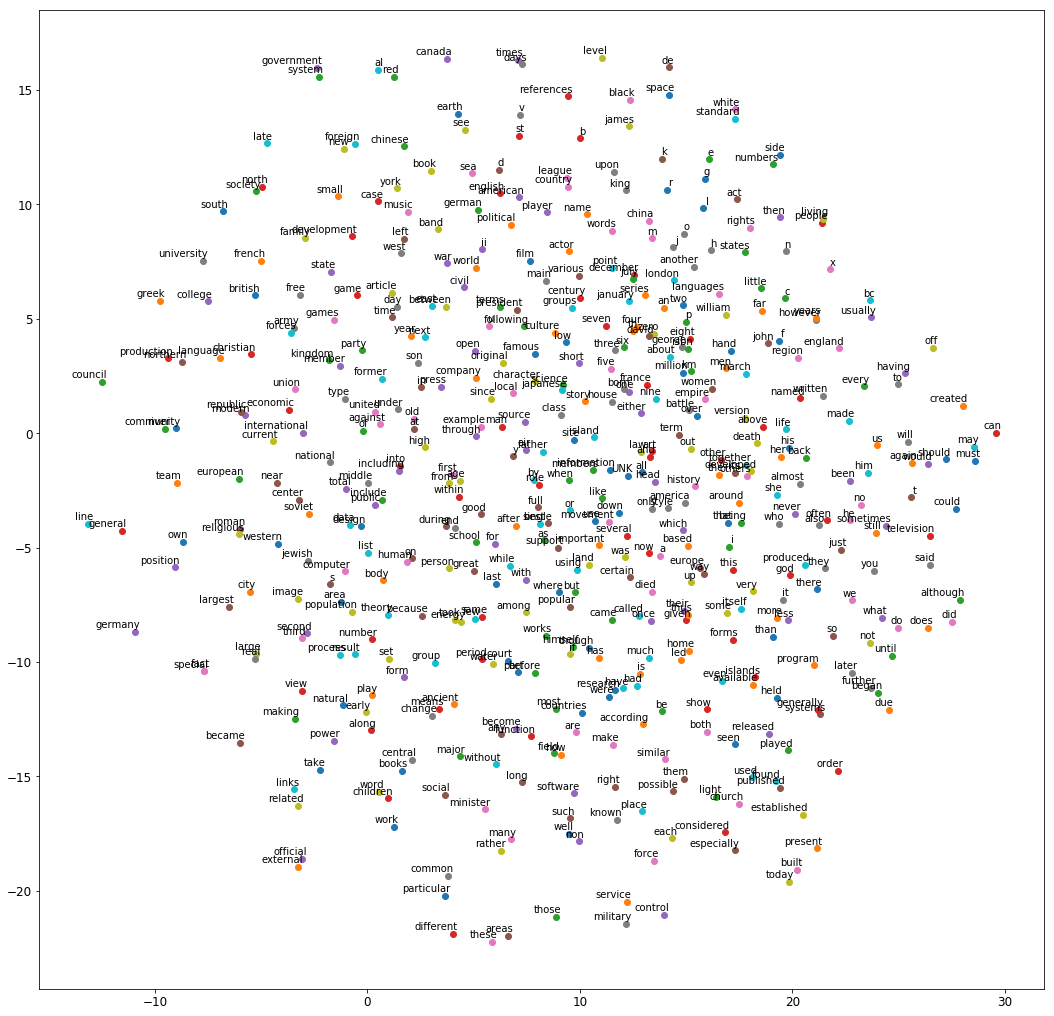

In [104]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [vocabulary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)
plt.show()
plt.clf()

### Machine Translation using Encoder - Decoder Network

A simple translation model that translates English sentences into French.

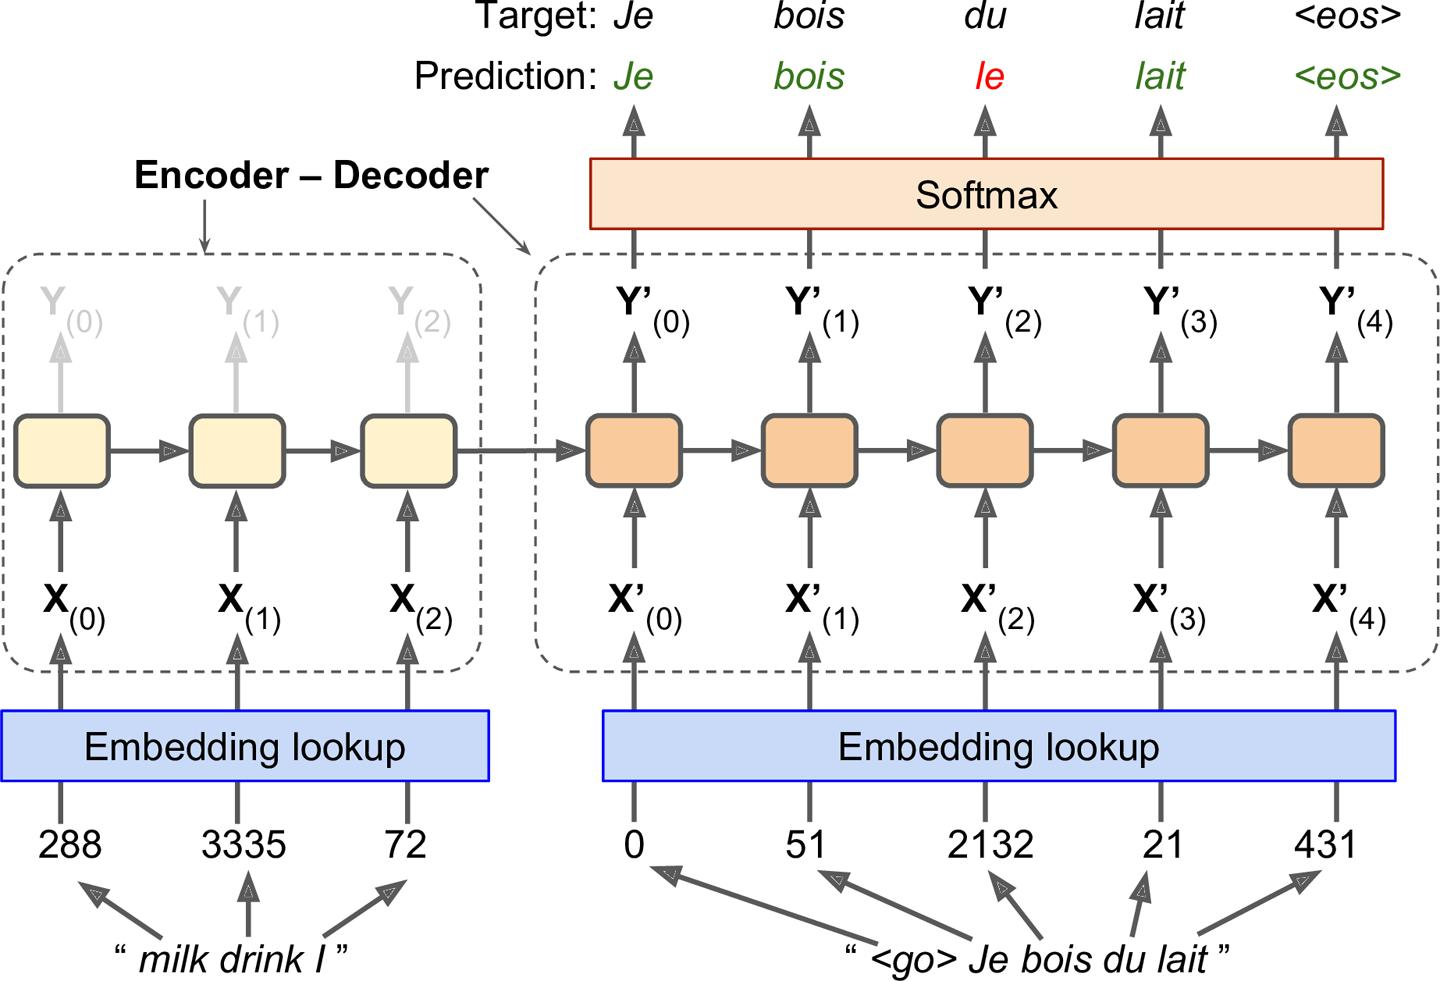

In [105]:
show_image('./images/img2864.jpg')

In this model, English sentences are fed into Encoder and the Decoder ouputs these sentences in French.

French translations are used as inputs to the decoder, but pushed back by one step. In other words, the decoder is given as input the word that it should have output at the previous step (regardless of what it actually output).

In decoder, for the first word, it is given a token representing the beginning of the sentence ($<go>$ for example). It is expected to end the sentence with an **end-of-sequence (EOS)** token ($<eos>$ for example).

English sentence is reversed before feeding to the encoder. This ensures that the beginning of the sentence will be fed last to the encoder (because it's the first thing that the decoder needs to translate).

Initially, each word is represented by an integer identifier. We then use embedding lookup to get the actual word embedding. These word embeddings are what is fed to the encoder and the decoder.

At each step, the decoder outputs a score for each word in the output vocabulary (French in our case), and the softmax layer turns these scores into probabilities. The word with the highest probability is output. This is like a regular classification task, so we can train the model with `softmax_cross_entropy_with_logits()` function.

During inference time, we don't have target sentence to feed to the decoder. Instead, we simply feed the decoder the word that it output at the previous step.

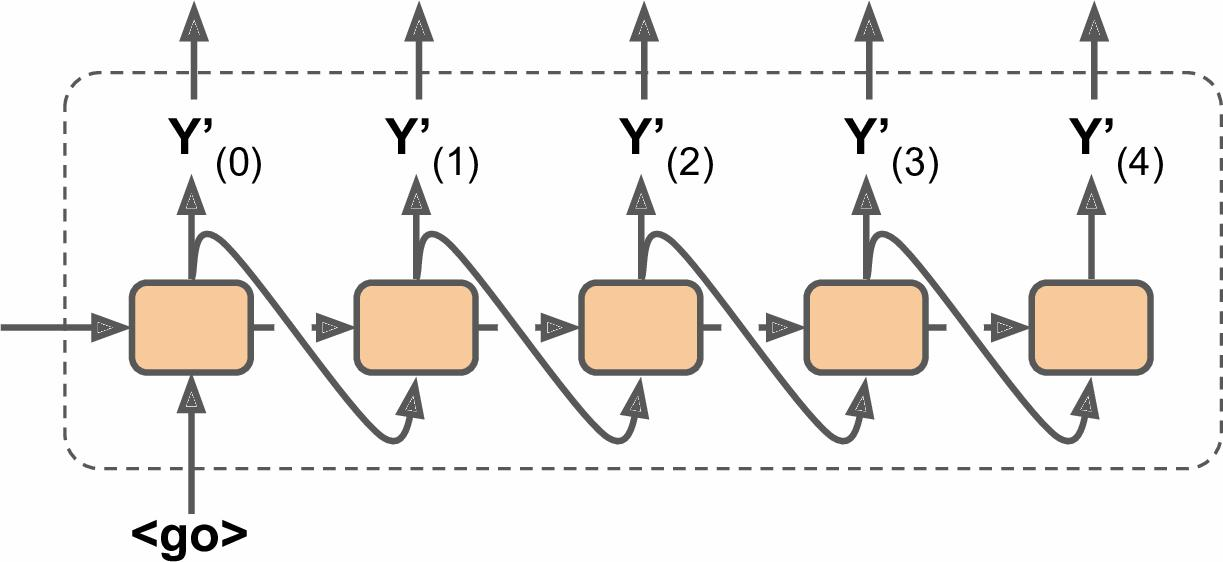

In [106]:
show_image('./images/img2870.jpg')

Ref: https://github.com/tensorflow/models/blob/master/tutorials/rnn/translate/seq2seq_model.py

Note about TensorFlow sequence-to-sequence tutorial above:

- So far we have assumed that all input sentences have a constant length. However, the length of sentences may vary. To tackle this problem, we can use `sequence_length` argument of the `static_rnn()` or `dynamic_rnn()` functions. In the tutorial, another approach is used. Sentences are grouped into buckets of similar lengths (for example, a bucket for the 1 to 6 words sentences are padded using a special padding token. For example, $I \space drink \space milk$ sentence will become $<pad><pad><pad> \space milk \space drink \space I$, and its translation becomes $Je \space bois \space du \space lait \space <eos><pad>$. We will ignore any output pas the EOS token. The tutorial implemented **target_weights** vector. By multiplying the losses by the target weights will zero out the losses that correspond the words past the EOS token.
- When the output vocabulary is large, outputting a probability for each and every possible word is slow. To avoid this, one solution is to let the decoder output much smaller vectors, then use a sampling technique to estimate the loss without having to compute it over every single word in the target vocabulary. This technique is called **Sampled Softmax**. In Tensorflow, we can use `sampled_softmax_loss()` function.
- The tutorial uses `tn.nn.legacy_seq2seq` module which provides tools to build encoder-decoder models.

## Exercises

Ex1: **Embedded Reber grammars** were used by Hochreiter and Schmidhuber in their
paper about LSTMs. They are artificial grammars that produce strings such as
“BPBTSXXVPSEPE.” Check out Jenny Orr’s [nice introduction](http://www.willamette.edu/~gorr/classes/cs449/reber.html) to this topic.
Choose a particular embedded Reber grammar (such as the one represented on
Jenny Orr’s page), then train an RNN to identify whether a string respects that
grammar or not. You will first need to write a function capable of generating a
training batch containing about 50% strings that respect the grammar, and 50%
that don’t.

**Reber Grammar**

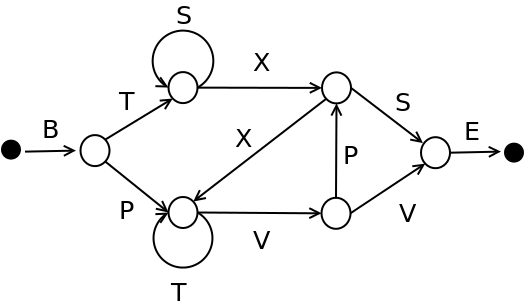

In [107]:
show_image('./images/img2901.png')

**Embedded Reber Grammar**

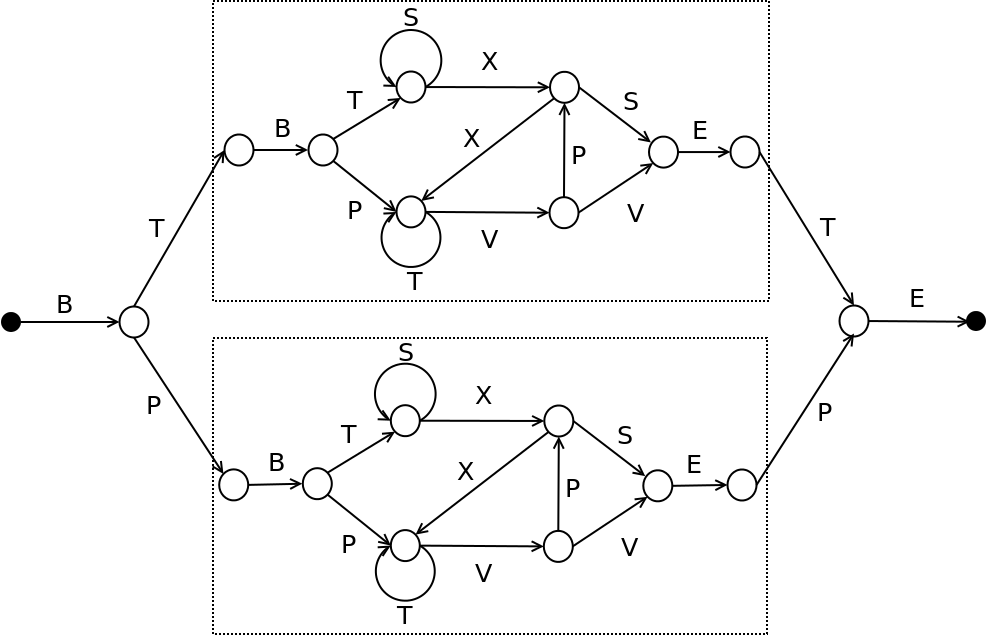

In [108]:
show_image('./images/img2902.png')

In [109]:
from random import choice, seed

seed(42)
np.random.seed(42)

In [110]:
# Define Reber grammar using state transitions.
# Each transition is represented as a tuple of string to output and the next state.
# Reber grammar has 6 states in total.
#    2    4
# 1           6
#    3    5
reber_grammar = [
    [("B", 1)],               # (state 0) => (state 1) -> B
    [("T", 2), ("P", 3)],     # (state 1) => (state 2) -> T | => (state 3) -> P
    [("S", 2), ("X", 4)],     # (state 2) => (state 2) -> S | => (state 4) -> X
    [("T", 3), ("V", 5)],     # (state 3) => (state 3) -> T | => (state 5) -> V
    [("X", 3), ("S", 6)],     # (state 4) => (state 3) -> X | => (state 6) -> S
    [("P", 4), ("V", 6)],     # (state 5) => (state 4) -> P | => (state 6) -> V
    [("E", None)]             # (state 6) => (end) -> E
]

In [111]:
# Define embedded Reber grammar
embedded_reber_grammar = [
    [("B", 1)],               # (state 0) => (state 1) -> B
    [("T", 2), ("P", 3)],     # (state 1) => (state 2) -> T | => (state 3) -> p
    [(reber_grammar, 4)],     # (state 2) => (state 4) -> reber_grammar
    [(reber_grammar, 5)],     # (state 3) => (state 5) -> reber_grammar
    [("T", 6)],               # (state 4) => (state 6) -> T
    [("P", 6)],               # (state 5) => (state 6) -> P
    [("E", None)]             # (state 6) => (end) -> E
]

In [112]:
def generate_reber_string(grammar):
    state = 0
    output = []
    while state is not None:
        production, state = choice(grammar[state])
        if isinstance(production, list):
            production = generate_reber_string(grammar=production)
        output.append(production)
    return "".join(output)

In [113]:
for _ in range(15):
    print(generate_reber_string(reber_grammar))

BTXXTTTTVPXTTTTTVPSE
BTXSE
BTXXTVPSE
BTXXVPSE
BTSSXXTTVVE
BTXSE
BTSSSXSE
BPTTTVVE
BTXXVVE
BPTTVVE
BTSXXTTTTVPSE
BPTTVVE
BPTVPSE
BPTTVPXVVE
BPVPXTTTVPXTVPSE


In [114]:
for _ in range(15):
    reber_string = generate_reber_string(embedded_reber_grammar)
    print(reber_string)

BTBPVVETE
BPBTSSSSSSXXTVVEPE
BPBTSXSEPE
BTBPTTTTVPSETE
BTBTSSSSXSETE
BTBPVVETE
BTBTSXXTVPXTTTTTVPXTTVVETE
BPBPVVEPE
BTBTXXTVVETE
BPBPTTTVVEPE
BPBTXSEPE
BPBPTTTTTVPSEPE
BTBTSXSETE
BPBPVPSEPE
BPBPVVEPE


In [115]:
def generate_corrupted_string(grammar, chars="BEPSTVX"):
    good_string = generate_reber_string(grammar)
    index = np.random.randint(len(good_string))
    good_char = good_string[index]
    bad_char = choice(list(set(chars) - set(good_char)))
    return good_string[:index] + bad_char + good_string[index + 1:]

In [116]:
for _ in range(25):
    print(generate_corrupted_string(embedded_reber_grammar))

BPBTXSPPE
BTBBXSETE
BPBTSXSXPE
BPBPXVEPE
BTBTXSBTE
BPBTSXSEPV
BTTTXXVVETE
BTBPTTEPXTVPSETE
BTBPTVVPTE
BTBVTTTTVPXTVVETE
BPBPVPSTPE
BPBPVPSBPE
BTSTXXVPXVVETE
BPBPTVPXVPXTTTTTTTTVPVVVEPE
BPBPVPXTTVPXVVETE
BPBPVPSBPE
BPBTXBEPE
BEBPTVVEPE
BTBPPPSETE
STBPVVETE
BPBTSSXXTTTBVEPE
BPBTSXXTVTSEPE
BPBTXTEPE
BTBPTTTVPSETT
BPBTSXXTTTTVTVVEPE


It's not possible to feed a string directly to an RNN. We need to convert it to a sequence of vectors. Each vector will represent a single letter, using a one-hot encoding. If the string is shorted than n_steps, it will be padded with zero vectors.

In [117]:
def convert_to_one_hot_vectors(string, n_steps, chars="BEPSTVX"):
    idxs = { char: idx for idx, char in enumerate(chars) }
    output = np.zeros((n_steps, len(chars)), dtype=np.int32)
    for idx, char in enumerate(string):
        output[idx][idxs[char]] = 1
    return output

In [118]:
convert_to_one_hot_vectors('BTBTXSTTE', 15)

array([[1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]], dtype=int32)

In [119]:
# Generate dataset with 50% of reber string and 50% of non-reber string
def generate_dataset(size):
    good = [generate_reber_string(embedded_reber_grammar)
            for _ in range(size // 2)]
    bad = [generate_corrupted_string(embedded_reber_grammar)
           for _ in range(size // 2)]
    all_strings = good + bad
    n_steps = max([len(string) for string in all_strings])
    X = np.array([convert_to_one_hot_vectors(string, n_steps)
                  for string in all_strings])
    seq_length = np.array([len(string) for string in all_strings])
    y = np.array([[1] for _ in range(len(good))] +
                 [[0] for _ in range(len(bad))])
    rnd_idx = np.random.permutation(size)
    return X[rnd_idx], y[rnd_idx], seq_length[rnd_idx]

In [120]:
X_train, y_train, seq_length_train = generate_dataset(10000)

In [121]:
X_train.shape

(10000, 43, 7)

In [122]:
y_train.shape

(10000, 1)

In [123]:
seq_length_train

array([15, 10, 13, ..., 12,  9, 10])

In [124]:
X_val, y_val, seq_length_val = generate_dataset(5000)

In [125]:
X_val.shape

(5000, 39, 7)

In [126]:
y_val.shape

(5000, 1)

In [127]:
seq_length_val

array([17, 11, 11, ..., 14, 13, 15])

In [128]:
reset_graph()

n_neurons = 30
n_outputs = 1
n_inputs = len("BEPSTVX")

learning_rate = 1e-3
momentum = 0.95

X = tf.placeholder(tf.float32, [None, None, n_inputs], name="X")
y = tf.placeholder(tf.float32, [None, 1], name="y")
seq_length = tf.placeholder(tf.int32, [None], name="seq_length")

gru_cell = tf.contrib.rnn.GRUCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(gru_cell, X, dtype=tf.float32,
                                    sequence_length=seq_length)

logits = tf.layers.dense(states, n_outputs, name="logits")
y_pred = tf.cast(tf.greater(logits, 0.), tf.float32, name="y_pred")

# We're performing binary classification, so we use 
# sigmoid_cross_entropy_with_logits() rather than
# spare_softmax_cross_entropy_with_logits()
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=momentum,
                                       use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.equal(y_pred, y, name="correct")
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

n_epochs = 150
batch_size = 60
init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        X_batches = np.array_split(X_train, len(X_train) // batch_size)
        y_batches = np.array_split(y_train, len(y_train) // batch_size)
        l_batches = np.array_split(seq_length_train, len(seq_length_train) // batch_size)
        for X_batch, l_batch, y_batch in zip(X_batches, l_batches, y_batches):
            loss_val, _ = sess.run(
                [loss, training_op],
                feed_dict={X: X_batch, seq_length: l_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, seq_length: l_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_val, seq_length: seq_length_val, y: y_val})
        print("{:4d}  Train loss: {:.4f}, accuracy: {:.2f}%  Validation accuracy: {:.2f}%".format(
            epoch, loss_val, 100 * acc_train, 100 * acc_val))
        saver.save(sess, "./models/reber/reber_classifier")

   0  Train loss: 0.6968, accuracy: 33.33%  Validation accuracy: 49.04%
   1  Train loss: 0.6958, accuracy: 40.00%  Validation accuracy: 53.02%
   2  Train loss: 0.6946, accuracy: 41.67%  Validation accuracy: 54.26%
   3  Train loss: 0.6934, accuracy: 41.67%  Validation accuracy: 55.56%
   4  Train loss: 0.6922, accuracy: 45.00%  Validation accuracy: 55.12%
   5  Train loss: 0.6911, accuracy: 45.00%  Validation accuracy: 55.20%
   6  Train loss: 0.6900, accuracy: 46.67%  Validation accuracy: 55.02%
   7  Train loss: 0.6889, accuracy: 48.33%  Validation accuracy: 55.32%
   8  Train loss: 0.6878, accuracy: 51.67%  Validation accuracy: 55.16%
   9  Train loss: 0.6867, accuracy: 51.67%  Validation accuracy: 55.22%
  10  Train loss: 0.6856, accuracy: 53.33%  Validation accuracy: 55.02%
  11  Train loss: 0.6845, accuracy: 51.67%  Validation accuracy: 54.34%
  12  Train loss: 0.6834, accuracy: 51.67%  Validation accuracy: 54.04%
  13  Train loss: 0.6823, accuracy: 60.00%  Validation accuracy:

 114  Train loss: 0.3802, accuracy: 81.67%  Validation accuracy: 87.16%
 115  Train loss: 0.1958, accuracy: 93.33%  Validation accuracy: 93.88%
 116  Train loss: 0.1699, accuracy: 95.00%  Validation accuracy: 95.88%
 117  Train loss: 0.1411, accuracy: 95.00%  Validation accuracy: 96.74%
 118  Train loss: 0.1300, accuracy: 96.67%  Validation accuracy: 97.32%
 119  Train loss: 0.1204, accuracy: 96.67%  Validation accuracy: 97.42%
 120  Train loss: 0.1208, accuracy: 96.67%  Validation accuracy: 97.70%
 121  Train loss: 0.1327, accuracy: 96.67%  Validation accuracy: 97.46%
 122  Train loss: 0.1120, accuracy: 96.67%  Validation accuracy: 97.66%
 123  Train loss: 0.1152, accuracy: 96.67%  Validation accuracy: 97.74%
 124  Train loss: 0.1108, accuracy: 96.67%  Validation accuracy: 97.94%
 125  Train loss: 0.1035, accuracy: 96.67%  Validation accuracy: 97.60%
 126  Train loss: 0.0907, accuracy: 96.67%  Validation accuracy: 97.84%
 127  Train loss: 0.2335, accuracy: 96.67%  Validation accuracy:

In [129]:
y_proba = tf.nn.sigmoid(logits)

test_strings = [
    "BPBTSSSSSSSSSSSSSXTTTTTVPXTTVPXTTTTVTTVPXVPXVPXTTTVVETE",
    "BPBTSSSSSSSSSSSSXXTTTTTVPXTTVPXTTTTTTTVPXVPXVPXTTTVVETE",
    "BPBTSSSSSSSSSSSSXXTTTTTVPXTTVPXTTTTTTTVPXVPXVPXTTTVVEPE"]
l_test = np.array([len(s) for s in test_strings])
max_length = l_test.max()
X_test = [convert_to_one_hot_vectors(s, n_steps=max_length)
          for s in test_strings]

with tf.Session() as sess:
    saver.restore(sess, "./models/reber/reber_classifier")
    y_proba_val = y_proba.eval(feed_dict={X: X_test, seq_length: l_test})

print()
print("Estimated probability that these are Reber strings:")
for index, string in enumerate(test_strings):
    print("{}: {:.2f}%".format(string, y_proba_val[index][0]))

INFO:tensorflow:Restoring parameters from ./models/reber/reber_classifier

Estimated probability that these are Reber strings:
BPBTSSSSSSSSSSSSSXTTTTTVPXTTVPXTTTTVTTVPXVPXVPXTTTVVETE: 0.00%
BPBTSSSSSSSSSSSSXXTTTTTVPXTTVPXTTTTTTTVPXVPXVPXTTTVVETE: 0.94%
BPBTSSSSSSSSSSSSXXTTTTTVPXTTVPXTTTTTTTVPXVPXVPXTTTVVEPE: 0.96%


Ex2: Tackle the “How much did it rain? II” [Kaggle competition](https://www.kaggle.com/c/how-much-did-it-rain-ii). This is a time series
prediction task: you are given snapshots of polarimetric radar values and asked to
predict the hourly rain gauge total. Luis Andre Dutra e Silva’s interview gives
some interesting insights into the techniques he used to reach second place in the
competition. In particular, he used an RNN composed of two LSTM layers.

https://www.kaggle.com/c/how-much-did-it-rain-ii/data

In [130]:
import sys

RAIN_DATASET_BASE_URL = 'https://www.dropbox.com/s/'
TRAIN_SET_URL = RAIN_DATASET_BASE_URL + "ytywzj58qvpr3hl/train.zip?dl=1"
TEST_SET_URL = RAIN_DATASET_BASE_URL + "748q1f8lovijokm/test.zip?dl=1"

RAIN_DATASET_PATH = os.path.join("datasets", "rain")
TRAIN_SET_PATH = os.path.join(RAIN_DATASET_PATH, "train.csv")
TEST_SET_PATH = os.path.join(RAIN_DATASET_PATH, "test.csv")

def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rDownloading: {}%".format(percent))
    sys.stdout.flush()

def fetch_rain_dataset(url, file_path, base_path=RAIN_DATASET_PATH):
    print("URL:", url)
    print("CSV:", file_path)
    if os.path.exists(file_path):
        return
    os.makedirs(base_path, exist_ok=True)
    zip_path = os.path.join(base_path, "rain.zip")
    print("Zip:", zip_path)
    urllib.request.urlretrieve(url, zip_path, reporthook=download_progress)
    
    with zipfile.ZipFile(zip_path) as zipper:
        zipper.extractall(path=base_path)
        zipper.close()
        os.remove(zip_path)

In [131]:
fetch_rain_dataset(url=TRAIN_SET_URL, file_path=TRAIN_SET_PATH)

URL: https://www.dropbox.com/s/ytywzj58qvpr3hl/train.zip?dl=1
CSV: datasets/rain/train.csv
Zip: datasets/rain/rain.zip
Downloading: 100%

In [132]:
fetch_rain_dataset(url=TEST_SET_URL, file_path=TEST_SET_PATH)

URL: https://www.dropbox.com/s/748q1f8lovijokm/test.zip?dl=1
CSV: datasets/rain/test.csv
Zip: datasets/rain/rain.zip
Downloading: 100%

Ex3: Go through TensorFlow’s [Word2Vec](https://www.tensorflow.org/tutorials/word2vec) tutorial to create word embeddings, and
then go through the [Seq2Seq](https://github.com/tensorflow/nmt) tutorial to train an English-to-French translation
system.